# Slide 1 — Drone Phenology Monitoring Overview
- **Project goal**: Monitor tree phenology on IIT Delhi campus using repeat drone surveys and an automated processing + tracking pipeline.
- **Study areas**: SAC; LHC front patch; SIT.
- **Data acquisition**: Nadir drone imagery, ~80% forward/side overlap, fixed altitude flight plans.
- **Processing**: Orthomosaics generated in WebODM; GPS coordinates transferred from XMP to EXIF for georeferencing consistency.
- **Tree analysis**: Crown detection via Detectree2 polygons; ground truth from CVAT-labeled crown polygons.
- **Outputs**: Georeferenced orthomosaics; per-date crown polygons; stable tree IDs across dates; phenology change summaries (leaf-on/off, flowering).
- **Current focus**: Robust tracking of individual trees across orthomosaics to enable temporal phenological metrics.

---
# Slide 2 — Work Done So Far
- **Acquisition**: Planned flight routes; repeated surveys (SAC, LHC, SIT); organized storage & naming convention.
- **WebODM processing**: Orthomosaics produced for each survey date; QC performed; reprojection handled where required.
- **Ground truth**: CVAT polygon crowns exported (shapefile / GeoJSON) for validation & metric computation.
- **Detection baseline**: Detectree2 tuned (tiling, buffer, threshold, simplify params currently fixed).
- **Temporal organization**: Detections stored by date & area with consistent spatial scale/tiling.
- **Current phase**: Implementing and refining multi-date crown matching to produce persistent IDs and prepare for phenology signal extraction (e.g., canopy area change, seasonal transitions).


In [2]:
import os
import re
import json
from dataclasses import dataclass, replace
from collections import defaultdict
from typing import Any, Dict, List, Optional, Tuple, Iterable

import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, Polygon
import networkx as nx


@dataclass
class MatchCaseConfig:
    name: str
    base_similarity_weights: Dict[str, float]
    scoring_weights: Dict[str, float]
    similarity_threshold: float
    min_iou: float = 0.0
    min_overlap_prev: float = 0.0
    min_overlap_curr: float = 0.0
    max_centroid_dist: Optional[float] = None
    mutual_best: bool = False
    allow_multiple: bool = False
    max_edges_per_prev: Optional[int] = None
    max_edges_per_curr: Optional[int] = None


class TreeTrackingGraph:
    """
    Self-contained tracker for tree crowns across orthomosaics using a directed graph.

    What this class does:
    - Discovers input files under input/input_crowns (*.gpkg) and input/input_om (*.tif)
    - Loads crown polygons (GeoPackages) and optionally extracts orthomosaic image patches per crown
    - Computes crown attributes (centroid, area, compactness, eccentricity, etc.)
    - Builds a tracking graph using a conditional-matching strategy (or legacy threshold-only)
    - Computes quality metrics and graph-complexity metrics
    - Performs threshold sweeps and saves results as JSON/TXT
    - Provides basic visualizations (now optional and commented out by default in the notebook)

    Typical usage:
      tracker = TreeTrackingGraph()
      tracker.load_data(load_images=False)
      tracker.build_graph_conditional()
      report, metrics = tracker.quality_report()
      comp_report, comp_metrics = tracker.complexity_report()
      # Visualization (optional): trackers expose helper methods, but notebook cells are commented to avoid heavy rendering.

    Notes:
    - Matching is between consecutive orthomosaics only (OM i -> OM i+1)
    - Conditional matching allows different cases (one-to-one, splits, merges, containment, proximity) with distinct thresholds
    - Legacy threshold-only matching is still available via build_graph_threshold / run_end_to_end(..., matching_strategy='threshold')
    """

    # ----------------------------
    # Construction and discovery
    # ----------------------------
    def __init__(
        self,
        crown_dir: Optional[str] = None,
        ortho_dir: Optional[str] = None,
        output_dir: str = '../../output',
        simplify_tol: float = 1.0,
        max_crowns_preview: int = 200,
        auto_discover: bool = True,
    ) -> None:
        self.output_dir = output_dir
        self.simplify_tol = simplify_tol
        self.max_crowns_preview = max_crowns_preview

        # Directories
        self.crown_dir = crown_dir or self._resolve_dir('input/input_crowns', '../../input/input_crowns')
        self.ortho_dir = ortho_dir or self._resolve_dir('input/input_om', '../../input/input_om')

        # File mappings and data containers
        self.file_pairs: List[Tuple[str, Optional[str]]] = []  # (crown_gpkg, ortho_tif)
        self.om_ids: List[int] = []                 # Sorted list of OM numeric ids
        self.crowns_gdfs: Dict[int, gpd.GeoDataFrame] = {}
        self.crown_attrs: Dict[int, List[Dict[str, Any]]] = {}
        self.crown_images: Dict[int, List[Optional[np.ndarray]]] = {}

        # Graph and matching configs
        self.G: nx.DiGraph = nx.DiGraph()
        self.case_configs: Dict[str, MatchCaseConfig] = self._default_case_configs()
        self.case_order: List[str] = ['one_to_one', 'containment', 'split', 'merge', 'partial_overlap', 'proximity']
        self.last_case_counts: Dict[str, int] = {}
        self.last_selected_counts: Dict[str, int] = {}

        if auto_discover:
            self.discover_files()

    @staticmethod
    def _resolve_dir(root_rel: str, nb_rel: str) -> str:
        candidates = [
            os.path.abspath(os.path.join(os.getcwd(), root_rel)),
            os.path.abspath(os.path.join(os.getcwd(), nb_rel)),
        ]
        for p in candidates:
            if os.path.isdir(p):
                return p
        raise FileNotFoundError(f"Could not resolve directory for {root_rel}. Tried: {candidates}")

    @staticmethod
    def _extract_numeric_id(name: str) -> Optional[int]:
        """Extract first integer found in a filename (e.g., OM3.gpkg -> 3, sit_om12.tif -> 12)."""
        m = re.search(r"(\d+)", os.path.basename(name))
        return int(m.group(1)) if m else None

    def discover_files(self) -> None:
        """
        Discover and pair crown .gpkg files and orthomosaic .tif files.
        Tries to pair by numeric id embedded in filenames; if missing, pairs by sorted order.
        Populates self.file_pairs and self.om_ids.
        """
        crown_files = [os.path.join(self.crown_dir, f) for f in os.listdir(self.crown_dir) if f.lower().endswith('.gpkg')]
        ortho_files = [os.path.join(self.ortho_dir, f) for f in os.listdir(self.ortho_dir) if f.lower().endswith('.tif')] if os.path.exists(self.ortho_dir) else []
        if not crown_files:
            raise FileNotFoundError(f"No .gpkg crown files found in {self.crown_dir}")
        if not ortho_files:
            # It's allowed to run without orthos if only polygons are needed
            ortho_files = []

        crowns_by_id = {}
        for cf in crown_files:
            cid = self._extract_numeric_id(cf)
            crowns_by_id[cid if cid is not None else cf] = cf

        orthos_by_id = {}
        for of in ortho_files:
            oid = self._extract_numeric_id(of)
            orthos_by_id[oid if oid is not None else of] = of

        # Intersect numeric ids if possible; otherwise fallback to sorted order
        numeric_ids = sorted(set(k for k in crowns_by_id.keys() if isinstance(k, int)) & set(k for k in orthos_by_id.keys() if isinstance(k, int)))
        file_pairs: List[Tuple[str, Optional[str]]] = []
        if numeric_ids:
            for nid in numeric_ids:
                file_pairs.append((crowns_by_id[nid], orthos_by_id.get(nid)))
            # Collect any crown-only entries that don't have an ortho pair
            crown_only = sorted(k for k in crowns_by_id.keys() if isinstance(k, int) and k not in numeric_ids)
            for nid in crown_only:
                file_pairs.append((crowns_by_id[nid], None))
        else:
            # Fallback: zip sorted by name
            crown_files_sorted = sorted(crown_files)
            ortho_files_sorted = sorted(ortho_files)
            for i, cf in enumerate(crown_files_sorted):
                of = ortho_files_sorted[i] if i < len(ortho_files_sorted) else None
                file_pairs.append((cf, of))

        # Determine OM ids in order
        om_ids: List[int] = []
        for cf, _ in file_pairs:
            cid = self._extract_numeric_id(cf)
            om_ids.append(cid if cid is not None else len(om_ids) + 1)

        # Sort by om id while keeping pairs aligned
        pairs_with_id = sorted([(oid, cf, of) for oid, (cf, of) in zip(om_ids, file_pairs)], key=lambda x: x[0])
        self.file_pairs = [(cf, of) for _, cf, of in pairs_with_id]
        self.om_ids = [oid for oid, _, _ in pairs_with_id]

    # ----------------------------
    # Loading and attributes
    # ----------------------------
    def load_data(self, load_images: bool = False) -> None:
        """
        Load crowns and compute attributes for each OM. Optionally extract image patches for each crown.
        Results are stored in:
          - self.crowns_gdfs[om_id] -> GeoDataFrame
          - self.crown_attrs[om_id] -> List[dict] per crown
          - self.crown_images[om_id] -> List[np.ndarray|None] per crown (only if load_images=True and .tif exists)
        """
        self.crowns_gdfs.clear()
        self.crown_attrs.clear()
        self.crown_images.clear()

        for om_id, (crown_file, ortho_file) in zip(self.om_ids, self.file_pairs):
            gdf = gpd.read_file(crown_file)
            self.crowns_gdfs[om_id] = gdf
            self.crown_attrs[om_id] = [self._compute_crown_attributes(row.geometry) for _, row in gdf.iterrows()]

            if load_images and ortho_file and os.path.exists(ortho_file):
                with rasterio.open(ortho_file) as src:
                    patches: List[Optional[np.ndarray]] = []
                    for _, row in gdf.iterrows():
                        geom = [mapping(row.geometry)]
                        try:
                            out_image, _ = mask(src, geom, crop=True)
                            img_patch = np.moveaxis(out_image, 0, -1)
                        except Exception:
                            img_patch = None
                        patches.append(img_patch)
                self.crown_images[om_id] = patches
            else:
                self.crown_images[om_id] = [None] * len(gdf)

    @staticmethod
    def _compute_crown_attributes(geometry) -> Dict[str, Any]:
        centroid = geometry.centroid
        area = geometry.area
        perimeter = geometry.length
        bounds = geometry.bounds
        compactness = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        # Eccentricity via minimum rotated rectangle
        try:
            min_rect = geometry.minimum_rotated_rectangle
            coords = list(min_rect.exterior.coords)
            side1 = np.linalg.norm(np.array(coords[0]) - np.array(coords[1]))
            side2 = np.linalg.norm(np.array(coords[1]) - np.array(coords[2]))
            major_axis = max(side1, side2)
            minor_axis = min(side1, side2)
            eccentricity = minor_axis / major_axis if major_axis > 0 else 1
        except Exception:
            eccentricity = 1
        aspect_ratio = (bounds[3] - bounds[1]) / (bounds[2] - bounds[0]) if bounds[2] != bounds[0] else 1
        return {
            'geometry': geometry,
            'centroid': centroid,
            'area': area,
            'perimeter': perimeter,
            'compactness': compactness,
            'eccentricity': eccentricity,
            'aspect_ratio': aspect_ratio,
            'bounds': bounds,
        }

    def _default_case_configs(self) -> Dict[str, MatchCaseConfig]:
        return {
            'one_to_one': MatchCaseConfig(
                name='one_to_one',
                base_similarity_weights={'spatial': 0.45, 'area': 0.2, 'shape': 0.15, 'iou': 0.2},
                scoring_weights={'base': 0.55, 'iou': 0.2, 'overlap_prev': 0.1, 'overlap_curr': 0.1, 'centroid': 0.05},
                similarity_threshold=0.72,
                min_iou=0.35,
                min_overlap_prev=0.65,
                min_overlap_curr=0.65,
                max_centroid_dist=45.0,
                mutual_best=True,
                allow_multiple=False,
                max_edges_per_prev=1,
                max_edges_per_curr=1,
            ),
            'containment': MatchCaseConfig(
                name='containment',
                base_similarity_weights={'spatial': 0.35, 'area': 0.15, 'shape': 0.15, 'iou': 0.35},
                scoring_weights={'base': 0.3, 'overlap_prev': 0.35, 'overlap_curr': 0.35},
                similarity_threshold=0.68,
                min_iou=0.25,
                min_overlap_prev=0.75,
                min_overlap_curr=0.75,
                max_centroid_dist=60.0,
                mutual_best=False,
                allow_multiple=False,
                max_edges_per_prev=1,
                max_edges_per_curr=1,
            ),
            'split': MatchCaseConfig(
                name='split',
                base_similarity_weights={'spatial': 0.35, 'area': 0.1, 'shape': 0.15, 'iou': 0.4},
                scoring_weights={'base': 0.25, 'iou': 0.25, 'overlap_prev': 0.35, 'overlap_curr': 0.05, 'area_balance': 0.1},
                similarity_threshold=0.58,
                min_iou=0.2,
                min_overlap_prev=0.45,
                min_overlap_curr=0.2,
                max_centroid_dist=55.0,
                mutual_best=False,
                allow_multiple=True,
                max_edges_per_prev=3,
                max_edges_per_curr=1,
            ),
            'merge': MatchCaseConfig(
                name='merge',
                base_similarity_weights={'spatial': 0.35, 'area': 0.15, 'shape': 0.15, 'iou': 0.35},
                scoring_weights={'base': 0.25, 'iou': 0.25, 'overlap_curr': 0.35, 'overlap_prev': 0.05, 'area_balance': 0.1},
                similarity_threshold=0.58,
                min_iou=0.2,
                min_overlap_prev=0.2,
                min_overlap_curr=0.45,
                max_centroid_dist=55.0,
                mutual_best=False,
                allow_multiple=True,
                max_edges_per_prev=1,
                max_edges_per_curr=3,
            ),
            'partial_overlap': MatchCaseConfig(
                name='partial_overlap',
                base_similarity_weights={'spatial': 0.5, 'area': 0.15, 'shape': 0.15, 'iou': 0.2},
                scoring_weights={'base': 0.45, 'iou': 0.2, 'overlap_prev': 0.15, 'overlap_curr': 0.15, 'centroid': 0.05},
                similarity_threshold=0.62,
                min_iou=0.18,
                min_overlap_prev=0.25,
                min_overlap_curr=0.25,
                max_centroid_dist=60.0,
                mutual_best=False,
                allow_multiple=False,
                max_edges_per_prev=1,
                max_edges_per_curr=1,
            ),
            'proximity': MatchCaseConfig(
                name='proximity',
                base_similarity_weights={'spatial': 0.6, 'area': 0.1, 'shape': 0.1, 'iou': 0.2},
                scoring_weights={'base': 0.3, 'centroid': 0.4, 'overlap_prev': 0.15, 'overlap_curr': 0.15},
                similarity_threshold=0.66,
                min_iou=0.05,
                min_overlap_prev=0.0,
                min_overlap_curr=0.0,
                max_centroid_dist=35.0,
                mutual_best=False,
                allow_multiple=False,
                max_edges_per_prev=1,
                max_edges_per_curr=1,
            ),
        }

    def _prepare_case_configs(self, case_configs: Optional[Dict[str, MatchCaseConfig]]) -> Dict[str, MatchCaseConfig]:
        if case_configs is None:
            return {name: replace(cfg) for name, cfg in self.case_configs.items()}
        prepared: Dict[str, MatchCaseConfig] = {}
        for name, cfg in case_configs.items():
            if isinstance(cfg, MatchCaseConfig):
                prepared[name] = replace(cfg)
            elif isinstance(cfg, dict):
                prepared[name] = MatchCaseConfig(name=name, **cfg)
            else:
                raise ValueError(f"Unsupported config type for case {name}: {type(cfg)}")
        return prepared

    # ----------------------------
    # Similarity and IoU
    # ----------------------------
    @staticmethod
    def _compute_iou(g1, g2) -> float:
        try:
            intersection = g1.intersection(g2).area
            union = g1.union(g2).area
        except Exception:
            intersection = 0.0
            union = g1.area + g2.area
        return intersection / union if union > 0 else 0.0

    def _weighted_similarity(
        self,
        a1: Dict[str, Any],
        a2: Dict[str, Any],
        weights: Optional[Dict[str, float]] = None,
        max_dist: float = 100.0,
    ) -> Tuple[float, Dict[str, float]]:
        if weights is None:
            weights = {'spatial': 0.4, 'area': 0.2, 'shape': 0.2, 'iou': 0.2}
        centroid_dist = a1['centroid'].distance(a2['centroid'])
        spatial_sim = max(0.0, 1.0 - (centroid_dist / max_dist))
        area_sim = min(a1['area'], a2['area']) / max(a1['area'], a2['area']) if max(a1['area'], a2['area']) > 0 else 0.0
        compactness_sim = 1.0 - abs(a1['compactness'] - a2['compactness'])
        eccentricity_sim = 1.0 - abs(a1['eccentricity'] - a2['eccentricity'])
        shape_sim = (compactness_sim + eccentricity_sim) / 2.0
        iou_sim = self._compute_iou(a1['geometry'], a2['geometry'])
        total = (
            weights.get('spatial', 0.0) * spatial_sim +
            weights.get('area', 0.0) * area_sim +
            weights.get('shape', 0.0) * shape_sim +
            weights.get('iou', 0.0) * iou_sim
        )
        return total, {
            'spatial': float(spatial_sim),
            'area': float(area_sim),
            'shape': float(shape_sim),
            'iou': float(iou_sim),
            'total': float(total),
        }

    def _compute_pair_metrics(
        self,
        prev_attrs: Dict[str, Any],
        curr_attrs: Dict[str, Any],
        max_dist: float,
    ) -> Dict[str, float]:
        prev_geom = prev_attrs['geometry']
        curr_geom = curr_attrs['geometry']
        try:
            intersection_geom = prev_geom.intersection(curr_geom)
            intersection_area = intersection_geom.area
        except Exception:
            intersection_area = 0.0
        try:
            union_area = prev_geom.union(curr_geom).area
        except Exception:
            union_area = prev_attrs['area'] + curr_attrs['area'] - intersection_area

        prev_area = prev_attrs['area'] if prev_attrs['area'] > 0 else 1e-6
        curr_area = curr_attrs['area'] if curr_attrs['area'] > 0 else 1e-6
        overlap_prev = intersection_area / prev_area
        overlap_curr = intersection_area / curr_area
        iou = intersection_area / union_area if union_area > 0 else 0.0
        centroid_dist = prev_attrs['centroid'].distance(curr_attrs['centroid'])
        base_similarity, parts = self._weighted_similarity(prev_attrs, curr_attrs, max_dist=max_dist)
        prev_radius = np.sqrt(prev_area / np.pi)
        curr_radius = np.sqrt(curr_area / np.pi)
        mean_radius = max((prev_radius + curr_radius) / 2.0, 1e-3)
        area_ratio = curr_area / prev_area if prev_area > 0 else np.inf
        if not np.isfinite(area_ratio) or area_ratio <= 0:
            balanced_area_ratio = 0.0
        else:
            balanced_area_ratio = area_ratio if area_ratio <= 1 else 1 / area_ratio

        try:
            prev_contains_curr = prev_geom.buffer(0).contains(curr_geom)
        except Exception:
            prev_contains_curr = False
        try:
            curr_contains_prev = curr_geom.buffer(0).contains(prev_geom)
        except Exception:
            curr_contains_prev = False

        return {
            'intersection_area': float(intersection_area),
            'union_area': float(union_area),
            'overlap_prev': float(overlap_prev),
            'overlap_curr': float(overlap_curr),
            'iou': float(iou),
            'centroid_dist': float(centroid_dist),
            'base_similarity': float(base_similarity),
            'spatial_similarity': float(parts['spatial']),
            'area_similarity': float(parts['area']),
            'shape_similarity': float(parts['shape']),
            'mean_radius': float(mean_radius),
            'area_ratio': float(area_ratio if np.isfinite(area_ratio) else 0.0),
            'balanced_area_ratio': float(balanced_area_ratio),
            'prev_contains_curr': bool(prev_contains_curr),
            'curr_contains_prev': bool(curr_contains_prev),
        }

    def _classify_match_case(
        self,
        prev_node: Tuple[int, int],
        curr_node: Tuple[int, int],
        features: Dict[str, float],
        prev_overlap_counts: Dict[Tuple[int, int], int],
        curr_overlap_counts: Dict[Tuple[int, int], int],
        overlap_gate: float,
    ) -> str:
        overlap_prev = features['overlap_prev']
        overlap_curr = features['overlap_curr']
        iou = features['iou']
        centroid_dist = features['centroid_dist']
        mean_radius = features['mean_radius']
        prev_count = prev_overlap_counts.get(prev_node, 0)
        curr_count = curr_overlap_counts.get(curr_node, 0)

        if features['prev_contains_curr'] or features['curr_contains_prev']:
            return 'containment'

        if prev_count == 1 and curr_count == 1 and overlap_prev >= 0.65 and overlap_curr >= 0.65 and iou >= 0.3:
            return 'one_to_one'

        if prev_count > 1 and overlap_prev >= max(0.4, overlap_gate):
            return 'split'

        if curr_count > 1 and overlap_curr >= max(0.4, overlap_gate):
            return 'merge'

        if iou >= 0.18 or max(overlap_prev, overlap_curr) >= max(0.3, overlap_gate):
            return 'partial_overlap'

        proximity_threshold = max(25.0, mean_radius * 2.0)
        if centroid_dist <= proximity_threshold:
            return 'proximity'

        return 'none'

    def _score_candidate(
        self,
        base_similarity: float,
        similarity_parts: Dict[str, float],
        features: Dict[str, float],
        config: MatchCaseConfig,
    ) -> float:
        centroid_factor = 1.0 - min(1.0, features['centroid_dist'] / (features['mean_radius'] * 3.0))
        components = {
            'base': base_similarity,
            'spatial': similarity_parts.get('spatial', 0.0),
            'area': similarity_parts.get('area', 0.0),
            'shape': similarity_parts.get('shape', 0.0),
            'iou': features['iou'],
            'overlap_prev': features['overlap_prev'],
            'overlap_curr': features['overlap_curr'],
            'centroid': max(0.0, centroid_factor),
            'area_balance': features.get('balanced_area_ratio', 0.0),
        }
        score = 0.0
        for key, weight in config.scoring_weights.items():
            score += weight * components.get(key, 0.0)
        return score

    def _select_candidates_by_case(
        self,
        candidates: List[Dict[str, Any]],
        configs: Dict[str, MatchCaseConfig],
        case_order: List[str],
        max_dist: float,
    ) -> List[Dict[str, Any]]:
        selected: List[Dict[str, Any]] = []
        used_prev: Dict[Tuple[int, int], int] = defaultdict(int)
        used_curr: Dict[Tuple[int, int], int] = defaultdict(int)

        for case_name in case_order:
            config = configs.get(case_name)
            if not config:
                continue
            case_candidates = [cand for cand in candidates if cand['case'] == case_name]
            if not case_candidates:
                continue

            enriched: List[Dict[str, Any]] = []
            for cand in case_candidates:
                prev_node = cand['prev_node']
                curr_node = cand['curr_node']
                prev_attrs = cand['prev_attrs']
                curr_attrs = cand['curr_attrs']
                features = cand['features']

                if config.max_centroid_dist is not None and features['centroid_dist'] > config.max_centroid_dist:
                    continue
                if features['iou'] < config.min_iou:
                    continue
                if features['overlap_prev'] < config.min_overlap_prev:
                    continue
                if features['overlap_curr'] < config.min_overlap_curr:
                    continue

                base_similarity, parts = self._weighted_similarity(
                    prev_attrs,
                    curr_attrs,
                    weights=config.base_similarity_weights,
                    max_dist=max_dist,
                )
                score = self._score_candidate(base_similarity, parts, features, config)
                if score < config.similarity_threshold:
                    continue

                cand['base_similarity'] = float(base_similarity)
                cand['similarity_parts'] = {k: float(v) for k, v in parts.items()}
                cand['score'] = float(score)
                enriched.append(cand)

            if not enriched:
                continue

            if config.mutual_best:
                best_prev: Dict[Tuple[int, int], Dict[str, Any]] = {}
                best_curr: Dict[Tuple[int, int], Dict[str, Any]] = {}
                for cand in enriched:
                    prev_node = cand['prev_node']
                    curr_node = cand['curr_node']
                    if used_prev.get(prev_node, 0) and not config.allow_multiple:
                        continue
                    if used_curr.get(curr_node, 0) and not config.allow_multiple:
                        continue
                    if cand['score'] < config.similarity_threshold:
                        continue
                    if prev_node not in best_prev or cand['score'] > best_prev[prev_node]['score']:
                        best_prev[prev_node] = cand
                    if curr_node not in best_curr or cand['score'] > best_curr[curr_node]['score']:
                        best_curr[curr_node] = cand

                for cand in enriched:
                    prev_node = cand['prev_node']
                    curr_node = cand['curr_node']
                    if best_prev.get(prev_node) is cand and best_curr.get(curr_node) is cand:
                        if not config.allow_multiple:
                            if used_prev.get(prev_node, 0) or used_curr.get(curr_node, 0):
                                continue
                        if config.max_edges_per_prev is not None and used_prev[prev_node] >= config.max_edges_per_prev:
                            continue
                        if config.max_edges_per_curr is not None and used_curr[curr_node] >= config.max_edges_per_curr:
                            continue
                        selected.append(cand)
                        used_prev[prev_node] += 1
                        used_curr[curr_node] += 1
            else:
                enriched.sort(key=lambda c: c['score'], reverse=True)
                for cand in enriched:
                    prev_node = cand['prev_node']
                    curr_node = cand['curr_node']
                    if not config.allow_multiple:
                        if used_prev.get(prev_node, 0) or used_curr.get(curr_node, 0):
                            continue
                    if config.max_edges_per_prev is not None and used_prev[prev_node] >= config.max_edges_per_prev:
                        continue
                    if config.max_edges_per_curr is not None and used_curr[curr_node] >= config.max_edges_per_curr:
                        continue
                    selected.append(cand)
                    used_prev[prev_node] += 1
                    used_curr[curr_node] += 1

        return selected

    # ----------------------------
    # Graph building (threshold-only and conditional)
    # ----------------------------
    def reset_graph(self) -> None:
        self.G = nx.DiGraph()

    def build_graph_threshold(
        self,
        threshold: float = 0.3,
        weights: Optional[Dict[str, float]] = None,
        max_dist: float = 100.0,
        max_centroid_dist: Optional[float] = None,
        min_iou: Optional[float] = None,
        top_k_per_prev: Optional[int] = None,
    ) -> None:
        """
        Build edges between consecutive OMs for all pairs with similarity >= threshold.
        - Allows multiple edges out of a node
        - Optional gating: max_centroid_dist, min_iou
        - Optional top_k_per_prev: keep only the top-K similar current nodes for each previous node
        """
        if not self.crowns_gdfs:
            # Default: load without images for speed
            self.load_data(load_images=False)
        self.reset_graph()

        for idx in range(len(self.om_ids)):
            om_id = self.om_ids[idx]
            gdf = self.crowns_gdfs[om_id]
            # Add nodes for this OM
            for crown_id, row in gdf.iterrows():
                attrs = self.crown_attrs[om_id][crown_id]
                self.G.add_node((om_id, crown_id), **attrs)

            # No predecessors for first OM
            if idx == 0:
                continue

            prev_om = self.om_ids[idx - 1]
            prev_nodes = [(prev_om, i) for i in range(len(self.crowns_gdfs[prev_om]))]
            curr_nodes = [(om_id, j) for j in range(len(gdf))]

            # Precompute candidate list per prev crown
            for prev_node in prev_nodes:
                prev_attrs = self.G.nodes[prev_node]
                candidates: List[Tuple[Tuple[int, int], float, Dict[str, float]]] = []
                for curr_node in curr_nodes:
                    curr_attrs = self.crown_attrs[om_id][curr_node[1]]
                    # Fast gates
                    if max_centroid_dist is not None:
                        if prev_attrs['centroid'].distance(curr_attrs['centroid']) > max_centroid_dist:
                            continue
                    if min_iou is not None:
                        iou_val = self._compute_iou(prev_attrs['geometry'], curr_attrs['geometry'])
                        if iou_val < min_iou:
                            continue
                    sim, parts = self._weighted_similarity(prev_attrs, curr_attrs, weights=weights, max_dist=max_dist)
                    if sim >= threshold:
                        candidates.append((curr_node, sim, parts))

                if top_k_per_prev is not None and len(candidates) > top_k_per_prev:
                    candidates = sorted(candidates, key=lambda x: x[1], reverse=True)[:top_k_per_prev]

                for curr_node, sim, parts in candidates:
                    self.G.add_edge(prev_node, curr_node, similarity=float(sim), method='threshold', **parts)

    def build_graph_conditional(
        self,
        case_configs: Optional[Dict[str, MatchCaseConfig]] = None,
        case_order: Optional[List[str]] = None,
        base_max_dist: float = 100.0,
        overlap_gate: float = 0.3,
        min_base_similarity: float = 0.2,
        max_candidates_per_prev: Optional[int] = None,
        max_candidates_per_curr: Optional[int] = None,
    ) -> None:
        if not self.crowns_gdfs:
            self.load_data(load_images=False)
        self.reset_graph()

        configs = self._prepare_case_configs(case_configs)
        order = case_order or self.case_order

        self.last_case_counts = {}
        self.last_selected_counts = {name: 0 for name in configs.keys()}

        for idx in range(len(self.om_ids)):
            om_id = self.om_ids[idx]
            gdf = self.crowns_gdfs[om_id]
            for crown_id, row in gdf.iterrows():
                attrs = self.crown_attrs[om_id][crown_id]
                self.G.add_node((om_id, crown_id), **attrs)

            if idx == 0:
                continue

            prev_om = self.om_ids[idx - 1]
            prev_nodes = [(prev_om, i) for i in range(len(self.crowns_gdfs[prev_om]))]
            curr_nodes = [(om_id, j) for j in range(len(gdf))]

            candidates: List[Dict[str, Any]] = []
            overlap_counts_prev: Dict[Tuple[int, int], int] = defaultdict(int)
            overlap_counts_curr: Dict[Tuple[int, int], int] = defaultdict(int)

            for prev_node in prev_nodes:
                prev_attrs = self.G.nodes[prev_node]
                for curr_node in curr_nodes:
                    curr_attrs = self.crown_attrs[om_id][curr_node[1]]
                    features = self._compute_pair_metrics(prev_attrs, curr_attrs, max_dist=base_max_dist)
                    if features['centroid_dist'] > base_max_dist:
                        continue
                    if features['base_similarity'] < min_base_similarity and features['iou'] < overlap_gate:
                        continue
                    candidates.append({
                        'prev_node': prev_node,
                        'curr_node': curr_node,
                        'prev_attrs': prev_attrs,
                        'curr_attrs': curr_attrs,
                        'features': features,
                    })
                    if features['overlap_prev'] >= overlap_gate:
                        overlap_counts_prev[prev_node] += 1
                    if features['overlap_curr'] >= overlap_gate:
                        overlap_counts_curr[curr_node] += 1

            if not candidates:
                continue

            for cand in candidates:
                cand['case'] = self._classify_match_case(
                    cand['prev_node'],
                    cand['curr_node'],
                    cand['features'],
                    overlap_counts_prev,
                    overlap_counts_curr,
                    overlap_gate,
                )

            candidates = [cand for cand in candidates if cand['case'] != 'none']
            if not candidates:
                continue

            if max_candidates_per_prev is not None:
                grouped_prev: Dict[Tuple[int, int], List[Dict[str, Any]]] = defaultdict(list)
                for cand in candidates:
                    grouped_prev[cand['prev_node']].append(cand)
                trimmed: List[Dict[str, Any]] = []
                for group in grouped_prev.values():
                    group.sort(key=lambda c: (c['features']['base_similarity'], c['features']['iou']), reverse=True)
                    trimmed.extend(group[:max_candidates_per_prev])
                candidates = trimmed

            if max_candidates_per_curr is not None:
                grouped_curr: Dict[Tuple[int, int], List[Dict[str, Any]]] = defaultdict(list)
                for cand in candidates:
                    grouped_curr[cand['curr_node']].append(cand)
                trimmed_curr: List[Dict[str, Any]] = []
                for group in grouped_curr.values():
                    group.sort(key=lambda c: (c['features']['base_similarity'], c['features']['iou']), reverse=True)
                    trimmed_curr.extend(group[:max_candidates_per_curr])
                candidates = trimmed_curr

            case_counts = defaultdict(int)
            for cand in candidates:
                case_counts[cand['case']] += 1
            for case_name, count in case_counts.items():
                self.last_case_counts[case_name] = self.last_case_counts.get(case_name, 0) + count

            selected = self._select_candidates_by_case(candidates, configs, order, base_max_dist)
            for cand in selected:
                case_name = cand['case']
                features = cand['features']
                similarity_parts = cand.get('similarity_parts', {})
                self.G.add_edge(
                    cand['prev_node'],
                    cand['curr_node'],
                    similarity=float(cand.get('score', features['base_similarity'])),
                    method='conditional',
                    case=case_name,
                    overlap_prev=float(features['overlap_prev']),
                    overlap_curr=float(features['overlap_curr']),
                    iou=float(features['iou']),
                    centroid_distance=float(features['centroid_dist']),
                    base_similarity=float(cand.get('base_similarity', features['base_similarity'])),
                    spatial_similarity=float(similarity_parts.get('spatial', features['spatial_similarity'])),
                    area_similarity=float(similarity_parts.get('area', features['area_similarity'])),
                    shape_similarity=float(similarity_parts.get('shape', features['shape_similarity'])),
                )
                self.last_selected_counts[case_name] = self.last_selected_counts.get(case_name, 0) + 1

    # ----------------------------
    # Reports and metrics
    # ----------------------------
    def quality_report(self) -> Tuple[str, Dict[str, Any]]:
        G = self.G
        om_ids = self.om_ids
        metrics: Dict[str, Any] = {
            'total_trees_detected': G.number_of_nodes(),
            'total_edges': G.number_of_edges(),
            'total_possible_matches': 0,
            'successful_matches': 0,
            'match_rate_by_om_pair': {},
            'chain_length_distribution': {},
            'average_chain_length': 0,
            'median_chain_length': 0,
            'max_chain_length': 0,
        }
        chains = self._extract_all_chains()
        chain_lengths = [len(chain) for chain in chains]
        if chain_lengths:
            metrics['average_chain_length'] = float(np.mean(chain_lengths))
            metrics['median_chain_length'] = float(np.median(chain_lengths))
            metrics['max_chain_length'] = int(max(chain_lengths))
            for length in chain_lengths:
                metrics['chain_length_distribution'][int(length)] = metrics['chain_length_distribution'].get(int(length), 0) + 1

        for i in range(len(om_ids) - 1):
            om1, om2 = om_ids[i], om_ids[i + 1]
            om1_nodes = [n for n in G.nodes if n[0] == om1]
            om2_nodes = [n for n in G.nodes if n[0] == om2]
            matches = sum(1 for u, v in G.edges() if u[0] == om1 and v[0] == om2)
            possible_matches = min(len(om1_nodes), len(om2_nodes))
            match_rate = matches / possible_matches if possible_matches > 0 else 0.0
            metrics['match_rate_by_om_pair'][f'{om1}->{om2}'] = {
                'matches': matches,
                'possible': possible_matches,
                'rate': float(match_rate),
            }
            metrics['total_possible_matches'] += possible_matches
            metrics['successful_matches'] += matches

        metrics['overall_match_rate'] = (
            metrics['successful_matches'] / metrics['total_possible_matches'] if metrics['total_possible_matches'] > 0 else 0.0
        )

        report = [
            "# Tree Tracking Quality Assessment Report",
            "",
            f"Total Trees Detected: {metrics['total_trees_detected']}",
            f"Total Tracking Edges: {metrics['total_edges']}",
            f"Overall Match Rate: {metrics['overall_match_rate']:.3f}",
            f"Average Chain Length: {metrics.get('average_chain_length', 0):.2f}",
            f"Maximum Chain Length: {metrics.get('max_chain_length', 0)}",
            "",
            "Match Rates by Orthomosaic Pair:",
        ]
        for pair, data in metrics['match_rate_by_om_pair'].items():
            report.append(f"- {pair}: {data['matches']}/{data['possible']} ({data['rate']:.3f})")
        report.append("\nChain Length Distribution:")
        for length, count in sorted(metrics['chain_length_distribution'].items()):
            report.append(f"- Length {length}: {count} trees")
        if self.last_selected_counts:
            report.append("\nEdge selection by case:")
            for case_name, count in sorted(self.last_selected_counts.items(), key=lambda kv: (-kv[1], kv[0])):
                total_candidates = self.last_case_counts.get(case_name, 0)
                if total_candidates:
                    ratio = count / total_candidates
                    report.append(f"- {case_name}: {count} / {total_candidates} ({ratio:.2f})")
                else:
                    report.append(f"- {case_name}: {count}")
        return "\n".join(report), metrics

    def graph_complexity_metrics(self) -> Dict[str, Any]:
        G = self.G
        out_deg = dict(G.out_degree())
        in_deg = dict(G.in_degree())
        def dist(vals: Iterable[int]) -> Dict[int, int]:
            hist: Dict[int, int] = {}
            for v in vals:
                hist[int(v)] = hist.get(int(v), 0) + 1
            return dict(sorted(hist.items()))
        out_degree_dist = dist(out_deg.values())
        in_degree_dist = dist(in_deg.values())
        zero_out = sum(1 for v in out_deg.values() if v == 0)
        zero_in = sum(1 for v in in_deg.values() if v == 0)
        # Components
        weak_comps = list(nx.weakly_connected_components(G))
        strong_comps = list(nx.strongly_connected_components(G))
        weak_sizes = sorted([len(c) for c in weak_comps], reverse=True)
        strong_sizes = sorted([len(c) for c in strong_comps], reverse=True)
        # Diameters per weak component (undirected view)
        UG = G.to_undirected()
        diameters: List[int] = []
        for comp in nx.connected_components(UG):
            sub = UG.subgraph(comp)
            if sub.number_of_nodes() <= 1:
                diameters.append(0)
            else:
                try:
                    diameters.append(int(nx.diameter(sub)))
                except Exception:
                    diameters.append(0)
        return {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'avg_out_degree': float(np.mean(list(out_deg.values()))) if out_deg else 0.0,
            'avg_in_degree': float(np.mean(list(in_deg.values()))) if in_deg else 0.0,
            'out_degree_distribution': out_degree_dist,
            'in_degree_distribution': in_degree_dist,
            'zero_out_degree_nodes': zero_out,
            'zero_in_degree_nodes': zero_in,
            'weak_components': len(weak_comps),
            'weak_component_sizes': weak_sizes,
            'strong_components': len(strong_comps),
            'strong_component_sizes': strong_sizes,
            'diameters': diameters,
            'average_diameter': float(np.mean(diameters)) if diameters else 0.0,
            'median_diameter': float(np.median(diameters)) if diameters else 0.0,
            'max_diameter': int(max(diameters)) if diameters else 0,
        }

    def complexity_report(self) -> Tuple[str, Dict[str, Any]]:
        m = self.graph_complexity_metrics()
        report = [
            "# Graph Complexity Report",
            "",
            f"Nodes: {m['num_nodes']}",
            f"Edges: {m['num_edges']}",
            f"Avg out-degree: {m['avg_out_degree']:.3f}",
            f"Avg in-degree: {m['avg_in_degree']:.3f}",
            f"Zero out-degree nodes: {m['zero_out_degree_nodes']}",
            f"Zero in-degree nodes: {m['zero_in_degree_nodes']}",
            f"Weakly connected components: {m['weak_components']} (sizes head: {m['weak_component_sizes'][:10]})",
            f"Strongly connected components: {m['strong_components']} (sizes head: {m['strong_component_sizes'][:10]})",
            f"Average diameter: {m['average_diameter']:.3f}",
            f"Median diameter: {m['median_diameter']:.3f}",
            f"Max diameter: {m['max_diameter']}",
        ]
        return "\n".join(report), m

    # ----------------------------
    # Utilities: chains, saving, sweeping
    # ----------------------------
    def _extract_all_chains(self) -> List[List[Tuple[int, int]]]:
        visited = set()
        chains: List[List[Tuple[int, int]]] = []
        chain_starts = [n for n in self.G.nodes if not list(self.G.predecessors(n))]
        for start_node in chain_starts:
            if start_node in visited:
                continue
            chain = self._greedy_chain(start_node)
            chains.append(chain)
            visited.update(chain)
        remaining = set(self.G.nodes) - visited
        for node in remaining:
            chains.append([node])
        return chains

    def _greedy_chain(self, start_node: Tuple[int, int]) -> List[Tuple[int, int]]:
        chain = [start_node]
        current = start_node
        while True:
            successors = list(self.G.successors(current))
            if not successors:
                break
            if len(successors) > 1:
                best_successor = max(successors, key=lambda n: self.G[current][n].get('similarity', 0.0))
                chain.append(best_successor)
                current = best_successor
            else:
                chain.append(successors[0])
                current = successors[0]
        return chain

    def get_matching_chain(self, start_om_id: int, crown_id: int) -> List[Tuple[int, int]]:
        """Return a greedy chain starting from (start_om_id, crown_id)."""
        node = (start_om_id, crown_id)
        if node not in self.G:
            raise ValueError(f"Node {(start_om_id, crown_id)} not in graph. Build the graph first.")
        return self._greedy_chain(node)

    def ensure_output_dir(self) -> None:
        os.makedirs(self.output_dir, exist_ok=True)

    def save_text(self, text: str, filename: str) -> str:
        self.ensure_output_dir()
        path = os.path.join(self.output_dir, filename)
        with open(path, 'w') as f:
            f.write(text)
        return path

    def save_json(self, data: Dict[str, Any], filename: str) -> str:
        self.ensure_output_dir()
        path = os.path.join(self.output_dir, filename)
        with open(path, 'w') as f:
            json.dump(data, f, indent=2)
        return path

    def sweep_thresholds(
        self,
        thresholds: Iterable[float],
        weights: Optional[Dict[str, float]] = None,
        max_dist: float = 100.0,
        max_centroid_dist: Optional[float] = None,
        min_iou: Optional[float] = None,
        top_k_per_prev: Optional[int] = None,
        load_images: bool = False,
    ) -> Dict[str, int]:
        """
        For each threshold in thresholds, build a fresh graph and record the number of edges.
        Returns a dict mapping threshold (as string) -> edge_count.
        """
        # Load once (reuse geometries/attrs across sweeps)
        if not self.crowns_gdfs:
            self.load_data(load_images=load_images)
        results: Dict[str, int] = {}
        for t in thresholds:
            self.build_graph_threshold(
                threshold=float(t),
                weights=weights,
                max_dist=max_dist,
                max_centroid_dist=max_centroid_dist,
                min_iou=min_iou,
                top_k_per_prev=top_k_per_prev,
            )
            results[f"{t:.1f}"] = self.G.number_of_edges()
        return results

    # ----------------------------
    # One-shot convenience runner
    # ----------------------------
    def run_end_to_end(
        self,
        threshold: float = 0.3,
        weights: Optional[Dict[str, float]] = None,
        max_dist: float = 100.0,
        max_centroid_dist: Optional[float] = None,
        min_iou: Optional[float] = None,
        top_k_per_prev: Optional[int] = None,
        load_images: bool = False,
        save_prefix: Optional[str] = None,
        matching_strategy: str = 'conditional',
        case_configs: Optional[Dict[str, MatchCaseConfig]] = None,
        case_order: Optional[List[str]] = None,
        conditional_params: Optional[Dict[str, Any]] = None,
    ) -> Dict[str, Any]:
        """
        Load data (if needed), build the graph once, compute and optionally save reports.
        Returns a dict with graph stats and paths to saved artifacts (if save_prefix provided).
        """
        if not self.crowns_gdfs:
            self.load_data(load_images=load_images)

        if matching_strategy == 'threshold':
            self.build_graph_threshold(
                threshold=threshold,
                weights=weights,
                max_dist=max_dist,
                max_centroid_dist=max_centroid_dist,
                min_iou=min_iou,
                top_k_per_prev=top_k_per_prev,
            )
        else:
            params = {
                'case_configs': case_configs,
                'case_order': case_order,
                'base_max_dist': max_dist,
            }
            if conditional_params:
                params.update(conditional_params)
            self.build_graph_conditional(**params)

        q_report, q_metrics = self.quality_report()
        c_report, c_metrics = self.complexity_report()
        artifacts: Dict[str, Optional[str]] = {
            'quality_report_path': None,
            'quality_metrics_path': None,
            'complexity_report_path': None,
            'complexity_metrics_path': None,
        }
        if save_prefix:
            artifacts['quality_report_path'] = self.save_text(q_report, f'{save_prefix}_quality_report.txt')
            artifacts['quality_metrics_path'] = self.save_json(q_metrics, f'{save_prefix}_quality_metrics.json')
            artifacts['complexity_report_path'] = self.save_text(c_report, f'{save_prefix}_complexity_report.txt')
            artifacts['complexity_metrics_path'] = self.save_json(c_metrics, f'{save_prefix}_complexity_metrics.json')
        return {
            'nodes': self.G.number_of_nodes(),
            'edges': self.G.number_of_edges(),
            'quality_report': q_report,
            'quality_metrics': q_metrics,
            'complexity_report': c_report,
            'complexity_metrics': c_metrics,
            **artifacts,
        }

    # ----------------------------
    # Visualization helpers (optional dependencies loaded lazily)
    # ----------------------------
    def plot_matching_chain(
        self,
        chain: List[Tuple[int, int]],
        show_images: bool = False,
        highlight_color: str = 'orange',
        normal_color: str = 'lightgray',
        figsize_scale: float = 4.0,
    ) -> None:
        """
        Plot the polygons for a chain across OMs (and optionally image patches if loaded).
        """
        import matplotlib.pyplot as plt
        if not self.crowns_gdfs:
            self.load_data(load_images=show_images)
        om_ids = self.om_ids
        n_oms = len(om_ids)
        if show_images:
            fig, axes = plt.subplots(2, n_oms, figsize=(figsize_scale * n_oms, figsize_scale * 2))
        else:
            fig, axes = plt.subplots(1, n_oms, figsize=(figsize_scale * n_oms, figsize_scale))
        for col, om_id in enumerate(om_ids):
            gdf = self.crowns_gdfs[om_id]
            if show_images:
                ax_poly = axes[0, col]
                ax_img = axes[1, col]
            else:
                ax_poly = axes[col]
                ax_img = None
            try:
                gdf.plot(ax=ax_poly, facecolor='none', edgecolor=normal_color, linewidth=1)
            except Exception:
                pass
            cn = [n for n in chain if n[0] == om_id]
            if cn:
                crown_id = cn[0][1]
                if 0 <= crown_id < len(gdf):
                    try:
                        gdf.iloc[[crown_id]].plot(ax=ax_poly, facecolor='none', edgecolor=highlight_color, linewidth=2.5)
                    except Exception:
                        pass
                if show_images and ax_img is not None:
                    img_patch = self.crown_images.get(om_id, [None] * len(gdf))[crown_id] if crown_id < len(gdf) else None
                    if img_patch is not None:
                        ax_img.imshow(img_patch)
                        ax_img.set_title(f'OM {om_id} Crown {crown_id}')
                    else:
                        ax_img.set_title(f'OM {om_id} Crown {crown_id}\n(No image)')
            ax_poly.set_title(f'OM {om_id}')
            ax_poly.axis('off')
            if show_images and ax_img is not None:
                ax_img.axis('off')
        plt.tight_layout()
        plt.show()

    def show_om_overlay(self, om_id: int, alpha: float = 0.5) -> None:
        """Overlay all crowns for a given OM on its orthomosaic using matplotlib."""
        import matplotlib.pyplot as plt
        if not self.crowns_gdfs:
            self.load_data(load_images=False)
        idx = self.om_ids.index(om_id)
        crown_file, ortho_file = self.file_pairs[idx]
        gdf = self.crowns_gdfs[om_id]

        if ortho_file and os.path.exists(ortho_file):
            with rasterio.open(ortho_file) as src:
                try:
                    img = src.read([1, 2, 3])
                    img = np.moveaxis(img, 0, -1)
                except Exception:
                    img = None
        else:
            img = None

        plt.figure(figsize=(8, 8))
        if img is not None:
            if img.dtype != np.uint8:
                img = ((img - img.min()) / (img.ptp() + 1e-9) * 255).astype(np.uint8)
            plt.imshow(img)
        try:
            gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='yellow', linewidth=1, alpha=alpha)
        except Exception:
            pass
        plt.title(f'OM {om_id} overlay')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def interactive_overview(self, om_id: Optional[int] = None, resize_factor: float = 0.15) -> None:
        """
        Interactive view (plotly) of crowns overlaid on orthomosaic for a chosen OM.
        Click a polygon to render its tracking chain using matplotlib.
        """
        try:
            import plotly.graph_objects as go
            from ipywidgets import Output, VBox, Button
            from IPython.display import display, clear_output
            import rasterio
            import rasterio.transform
            import cv2
        except Exception as e:
            print("Interactive dependencies not available (plotly, ipywidgets, cv2).", e)
            return

        if not self.crowns_gdfs:
            self.load_data(load_images=False)
        if om_id is None:
            om_id = self.om_ids[0]
        idx = self.om_ids.index(om_id)
        crown_file, ortho_file = self.file_pairs[idx]
        gdf = self.crowns_gdfs[om_id]

        if not ortho_file or not os.path.exists(ortho_file):
            print("No orthomosaic available for interactive view.")
            return

        with rasterio.open(ortho_file) as src:
            try:
                ortho_img = src.read([1, 2, 3])
                ortho_img = np.moveaxis(ortho_img, 0, -1)
            except Exception:
                print("Could not read RGB bands from orthomosaic.")
                return
            if ortho_img.dtype != np.uint8:
                ortho_img = ((ortho_img - ortho_img.min()) / (ortho_img.ptp() + 1e-9) * 255).astype(np.uint8)
            h, w = ortho_img.shape[:2]
            ortho_img_small = cv2.resize(ortho_img, (int(w * resize_factor), int(h * resize_factor)))
            transform = src.transform

        fig = go.FigureWidget()
        fig.add_trace(go.Image(z=ortho_img_small))
        traces = []
        for idx_row, row in gdf.head(self.max_crowns_preview).iterrows():
            geom = row.geometry
            if isinstance(geom, Polygon):
                simple = geom.simplify(self.simplify_tol)
                x_geo, y_geo = simple.exterior.xy
                rows, cols = rasterio.transform.rowcol(transform, x_geo, y_geo)
                x_pix = np.array(cols) * resize_factor
                y_pix = np.array(rows) * resize_factor
                tr = go.Scatter(x=x_pix, y=y_pix, mode='lines', name=f'Crown {idx_row}', customdata=[idx_row], hoverinfo='name', line=dict(width=2))
                fig.add_trace(tr)
                traces.append(tr)
        fig.update_layout(title=f"OM {om_id} - Click a crown to visualize chain", dragmode='select', height=900, xaxis=dict(visible=False), yaxis=dict(visible=False))

        out = Output()
        back_btn = Button(description='Back', button_style='info')

        def show_chain(cid: int):
            with out:
                clear_output()
                try:
                    if self.G.number_of_nodes() == 0:
                        self.build_graph_conditional()
                    chain = self.get_matching_chain(om_id, cid)
                    self.plot_matching_chain(chain, show_images=False)
                except Exception as e:
                    print("Error plotting chain:", e)
                display(back_btn)

        def on_click(trace, points, selector):
            if points.point_inds:
                cid = trace.customdata[0]
                show_chain(cid)

        for tr in traces:
            tr.on_click(on_click)

        def go_back(btn):
            with out:
                clear_output()
                print("Select a crown to view its tracking chain.")
        back_btn.on_click(go_back)

        with out:
            print("Select a crown to view its tracking chain.")
        from ipywidgets import VBox as _VBox
        display(_VBox([fig, out]))


In [3]:
# Run TreeTrackingGraph pipelines with conditional matching variants and compare against legacy threshold

print("=== Conditional run (strict, high-confidence) ===")
tracker_strict = TreeTrackingGraph()
conditional_params_strict = {
    'overlap_gate': 0.40,
    'min_base_similarity': 0.30,
    'max_candidates_per_prev': 5,
    'max_candidates_per_curr': 4,
}
res_conditional_strict = tracker_strict.run_end_to_end(
    max_dist=75.0,
    load_images=False,
    save_prefix="conditional_strict",
    matching_strategy='conditional',
    conditional_params=conditional_params_strict,
 )
print(f"Nodes: {res_conditional_strict['nodes']}, Edges: {res_conditional_strict['edges']}")
print("Selected edges by case:")
for case_name, count in tracker_strict.last_selected_counts.items():
    candidate_count = tracker_strict.last_case_counts.get(case_name, 0)
    ratio = (count / candidate_count) if candidate_count else 0.0
    print(f"  {case_name:<16} -> {count:5d} edges (kept {ratio:.2f} of {candidate_count})")

print("\n=== Conditional run (balanced) ===")
tracker_balanced = TreeTrackingGraph()
conditional_params_balanced = {
    'overlap_gate': 0.32,
    'min_base_similarity': 0.25,
    'max_candidates_per_prev': 6,
    'max_candidates_per_curr': 5,
}
res_conditional_balanced = tracker_balanced.run_end_to_end(
    max_dist=85.0,
    load_images=False,
    save_prefix="conditional_balanced",
    matching_strategy='conditional',
    conditional_params=conditional_params_balanced,
 )
print(f"Nodes: {res_conditional_balanced['nodes']}, Edges: {res_conditional_balanced['edges']}")
print("Selected edges by case:")
for case_name, count in tracker_balanced.last_selected_counts.items():
    candidate_count = tracker_balanced.last_case_counts.get(case_name, 0)
    ratio = (count / candidate_count) if candidate_count else 0.0
    print(f"  {case_name:<16} -> {count:5d} edges (kept {ratio:.2f} of {candidate_count})")

print("\n=== Legacy threshold run @ threshold 0.7 (comparison baseline) ===")
tracker_threshold = TreeTrackingGraph()
res_threshold = tracker_threshold.run_end_to_end(
    threshold=0.7,
    max_centroid_dist=50.0,
    min_iou=0.05,
    load_images=False,
    matching_strategy='threshold',
    save_prefix=None,
 )
print(f"Nodes: {res_threshold['nodes']}, Edges: {res_threshold['edges']}")

=== Conditional run (strict, high-confidence) ===
Nodes: 626, Edges: 51
Selected edges by case:
  one_to_one       ->     9 edges (kept 1.00 of 9)
  containment      ->     0 edges (kept 0.00 of 2)
  split            ->     2 edges (kept 0.12 of 16)
  merge            ->     1 edges (kept 0.17 of 6)
  partial_overlap  ->    39 edges (kept 0.24 of 165)
  proximity        ->     0 edges (kept 0.00 of 1422)

=== Conditional run (balanced) ===
Nodes: 626, Edges: 51
Selected edges by case:
  one_to_one       ->     9 edges (kept 1.00 of 9)
  containment      ->     0 edges (kept 0.00 of 2)
  split            ->     2 edges (kept 0.12 of 16)
  merge            ->     1 edges (kept 0.17 of 6)
  partial_overlap  ->    39 edges (kept 0.24 of 165)
  proximity        ->     0 edges (kept 0.00 of 1422)

=== Conditional run (balanced) ===
Nodes: 626, Edges: 50
Selected edges by case:
  one_to_one       ->     9 edges (kept 1.00 of 9)
  containment      ->     0 edges (kept 0.00 of 3)
  split       

In [5]:
"""Show all metrics for the latest conditional runs and the threshold baseline.
If those variables aren't present yet, the runs are executed now."""
import json

STRICT_PARAMS_DEFAULT = {
    'overlap_gate': 0.40,
    'min_base_similarity': 0.30,
    'max_candidates_per_prev': 5,
    'max_candidates_per_curr': 4,
}
BALANCED_PARAMS_DEFAULT = {
    'overlap_gate': 0.32,
    'min_base_similarity': 0.25,
    'max_candidates_per_prev': 6,
    'max_candidates_per_curr': 5,
}

def _ensure_runs():
    global tracker_strict, tracker_balanced, tracker_threshold
    global res_conditional_strict, res_conditional_balanced, res_threshold
    try:
        _ = res_conditional_strict
        _ = res_conditional_balanced
        _ = res_threshold
        return
    except NameError:
        pass

    print("Running trackers to produce metrics (conditional + threshold baseline)...")
    strict_params = globals().get('conditional_params_strict', STRICT_PARAMS_DEFAULT)
    tracker_strict = TreeTrackingGraph()
    res_conditional_strict = tracker_strict.run_end_to_end(
        max_dist=75.0,
        load_images=False,
        matching_strategy='conditional',
        conditional_params=strict_params,
        save_prefix=None,
    )

    balanced_params = globals().get('conditional_params_balanced', BALANCED_PARAMS_DEFAULT)
    tracker_balanced = TreeTrackingGraph()
    res_conditional_balanced = tracker_balanced.run_end_to_end(
        max_dist=85.0,
        load_images=False,
        matching_strategy='conditional',
        conditional_params=balanced_params,
        save_prefix=None,
    )

    tracker_threshold = TreeTrackingGraph()
    res_threshold = tracker_threshold.run_end_to_end(
        threshold=0.7,
        max_centroid_dist=50.0,
        min_iou=0.05,
        load_images=False,
        matching_strategy='threshold',
        save_prefix=None,
    )

def _print_case_summary(tag: str, tracker: TreeTrackingGraph):
    print(f"Case selection summary for {tag}:")
    if not tracker.last_selected_counts:
        print("  No edges were selected.")
        return
    for case_name, count in sorted(tracker.last_selected_counts.items(), key=lambda kv: (-kv[1], kv[0])):
        total = tracker.last_case_counts.get(case_name, 0)
        ratio = (count / total) if total else 0.0
        print(f"  {case_name:<16} -> {count:5d} edges (kept {ratio:.2f} of {total})")
    print()

def _print_reports(tag: str, res: dict, tracker: Optional[TreeTrackingGraph] = None):
    print(f"\n=== {tag} ===")
    print("\n-- Quality report --\n")
    print(res['quality_report'])
    print("\n-- Complexity report --\n")
    print(res['complexity_report'])
    if tracker is not None:
        _print_case_summary(tag, tracker)

print("=== Metrics across strategies ===")
_ensure_runs()
_print_reports("Conditional (strict)", res_conditional_strict, tracker_strict)
_print_reports("Conditional (balanced)", res_conditional_balanced, tracker_balanced)
_print_reports("Threshold baseline", res_threshold, tracker_threshold)

=== Metrics across strategies ===

=== Conditional (strict) ===

-- Quality report --

# Tree Tracking Quality Assessment Report

Total Trees Detected: 626
Total Tracking Edges: 51
Overall Match Rate: 0.107
Average Chain Length: 1.09
Maximum Chain Length: 4

Match Rates by Orthomosaic Pair:
- 1->2: 9/80 (0.113)
- 2->3: 11/116 (0.095)
- 3->4: 17/130 (0.131)
- 4->5: 14/150 (0.093)

Chain Length Distribution:
- Length 1: 530 trees
- Length 2: 40 trees
- Length 3: 4 trees
- Length 4: 1 trees

Edge selection by case:
- partial_overlap: 39 / 165 (0.24)
- one_to_one: 9 / 9 (1.00)
- split: 2 / 16 (0.12)
- merge: 1 / 6 (0.17)
- containment: 0 / 2 (0.00)
- proximity: 0 / 1422 (0.00)

-- Complexity report --

# Graph Complexity Report

Nodes: 626
Edges: 51
Avg out-degree: 0.081
Avg in-degree: 0.081
Zero out-degree nodes: 575
Zero in-degree nodes: 575
Weakly connected components: 575 (sizes head: [4, 3, 3, 3, 3, 2, 2, 2, 2, 2])
Strongly connected components: 626 (sizes head: [1, 1, 1, 1, 1, 1, 1, 

In [6]:
# Summaries for high-confidence chains derived from the strict conditional run
from itertools import islice
from typing import Set

def _edge_info(tracker: TreeTrackingGraph, chain: List[Tuple[int, int]]):
    for u, v in zip(chain, chain[1:]):
        data = tracker.G.get_edge_data(u, v)
        if data:
            yield u, v, data
        else:
            yield u, v, {}

def _filter_high_confidence_chains(tracker: TreeTrackingGraph, min_similarity: float = 0.75, allowed_cases: Optional[Set[str]] = None):
    if allowed_cases is None:
        allowed_cases = {'one_to_one', 'containment'}
    chains = tracker._extract_all_chains()
    high_conf = []
    for chain in chains:
        if len(chain) < 2:
            continue
        edges = list(_edge_info(tracker, chain))
        if not edges:
            continue
        if all(
            edge_data.get('case') in allowed_cases and edge_data.get('similarity', 0.0) >= min_similarity
            for _, _, edge_data in edges
        ):
            high_conf.append(chain)
    return high_conf

def _describe_chain(chain: List[Tuple[int, int]], tracker: TreeTrackingGraph) -> str:
    edges = list(_edge_info(tracker, chain))
    similarities = [edge_data.get('similarity', 0.0) for _, _, edge_data in edges]
    cases = [edge_data.get('case') for _, _, edge_data in edges]
    return (
        f"length={len(chain)} | cases={cases} | "
        f"avg_sim={np.mean(similarities):.3f} | min_sim={np.min(similarities):.3f} | "
        f"nodes={chain}"
    )

print("=== Top high-confidence chains (strict run) ===")
_ensure_runs()
high_conf_strict = _filter_high_confidence_chains(tracker_strict, min_similarity=0.78, allowed_cases={'one_to_one'})
high_conf_strict.sort(key=len, reverse=True)
if not high_conf_strict:
    print("No high-confidence chains found.")
else:
    for idx, chain in enumerate(islice(high_conf_strict, 10), start=1):
        print(f"{idx:02d}. {_describe_chain(chain, tracker_strict)}")

print("\n=== High-confidence chains (balanced run, allowing containment) ===")
high_conf_balanced = _filter_high_confidence_chains(tracker_balanced, min_similarity=0.72, allowed_cases={'one_to_one', 'containment'})
high_conf_balanced.sort(key=len, reverse=True)
if not high_conf_balanced:
    print("No high-confidence chains found for the balanced run.")
else:
    for idx, chain in enumerate(islice(high_conf_balanced, 10), start=1):
        print(f"{idx:02d}. {_describe_chain(chain, tracker_balanced)}")

=== Top high-confidence chains (strict run) ===
01. length=2 | cases=['one_to_one'] | avg_sim=0.832 | min_sim=0.832 | nodes=[(1, 69), (2, 85)]
02. length=2 | cases=['one_to_one'] | avg_sim=0.839 | min_sim=0.839 | nodes=[(4, 3), (5, 9)]
03. length=2 | cases=['one_to_one'] | avg_sim=0.824 | min_sim=0.824 | nodes=[(4, 142), (5, 82)]

=== High-confidence chains (balanced run, allowing containment) ===
01. length=3 | cases=['one_to_one', 'one_to_one'] | avg_sim=0.774 | min_sim=0.771 | nodes=[(2, 60), (3, 42), (4, 84)]
02. length=2 | cases=['one_to_one'] | avg_sim=0.833 | min_sim=0.833 | nodes=[(1, 69), (2, 85)]
03. length=2 | cases=['one_to_one'] | avg_sim=0.761 | min_sim=0.761 | nodes=[(3, 47), (4, 19)]
04. length=2 | cases=['one_to_one'] | avg_sim=0.776 | min_sim=0.776 | nodes=[(3, 128), (4, 30)]
05. length=2 | cases=['one_to_one'] | avg_sim=0.839 | min_sim=0.839 | nodes=[(4, 3), (5, 9)]
06. length=2 | cases=['one_to_one'] | avg_sim=0.824 | min_sim=0.824 | nodes=[(4, 142), (5, 82)]


In [ ]:
# # Visualization tests: plot a chain, OM overlay, and interactive overview
# print("=== Visualization tests @ threshold 0.7 ===")

# # Build tracker and graph
# viz_tracker = TreeTrackingGraph()
# viz_tracker.run_end_to_end(threshold=0.7, load_images=False, save_prefix=None)

# # Pick a starting node in the first OM with at least one successor
# start_node = None
# if viz_tracker.om_ids:
#     first_om = viz_tracker.om_ids[0]
#     for n in viz_tracker.G.nodes:
#         if n[0] == first_om and any(viz_tracker.G.successors(n)):
#             start_node = n
#             break
#     # fallback: any node from first OM
#     if start_node is None:
#         for n in viz_tracker.G.nodes:
#             if n[0] == first_om:
#                 start_node = n
#                 break
# else:
#     raise RuntimeError("No OM ids found; ensure input files exist under input/input_crowns and input/input_om")

# if start_node is None:
#     raise RuntimeError("Could not find a suitable start node for visualization.")

# print(f"Using start node: {start_node}")
# chain = viz_tracker.get_matching_chain(start_om_id=start_node[0], crown_id=start_node[1])
# print(f"Chain length: {len(chain)}")

# # 1) Plot the chain polygons across OMs (no images loaded)
# viz_tracker.plot_matching_chain(chain, show_images=False)

# # 2) Show OM overlay for the first OM
# viz_tracker.show_om_overlay(om_id=first_om, alpha=0.6)

# # 3) Optional: Interactive overview (requires plotly + ipywidgets + cv2); safe to call even if not installed
# print("Launching interactive overview (if dependencies are available)...")
# viz_tracker.interactive_overview(om_id=first_om, resize_factor=0.12)

=== Selecting component with diameter=29 (graph built at threshold=0.7) ===
Found component with diameter 29.
Selected component has 261 nodes.
  OM 1 -> Crown 0
  OM 1 -> Crown 1
  OM 1 -> Crown 3
  OM 1 -> Crown 4
  OM 1 -> Crown 5
  OM 1 -> Crown 6
  OM 1 -> Crown 7
  OM 1 -> Crown 8
  OM 1 -> Crown 9
  OM 1 -> Crown 11
  OM 1 -> Crown 12
  OM 1 -> Crown 13
  OM 1 -> Crown 14
  OM 1 -> Crown 16
  OM 1 -> Crown 17
  OM 1 -> Crown 18
  OM 1 -> Crown 21
  OM 1 -> Crown 22
  OM 1 -> Crown 27
  OM 1 -> Crown 38
  OM 1 -> Crown 41
  OM 1 -> Crown 44
  OM 1 -> Crown 45
  OM 1 -> Crown 46
  OM 1 -> Crown 63
  OM 1 -> Crown 64
  OM 1 -> Crown 66
  OM 1 -> Crown 69
  OM 1 -> Crown 70
  OM 1 -> Crown 71
  OM 1 -> Crown 72
  OM 1 -> Crown 77
  OM 2 -> Crown 0
  OM 2 -> Crown 2
  OM 2 -> Crown 3
  OM 2 -> Crown 4
  OM 2 -> Crown 5
  OM 2 -> Crown 10
  OM 2 -> Crown 23
  OM 2 -> Crown 24
  OM 2 -> Crown 26
  OM 2 -> Crown 28
  OM 2 -> Crown 29
  OM 2 -> Crown 30
  OM 2 -> Crown 31
  OM 2 -> Crown

/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_98021/50987412.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


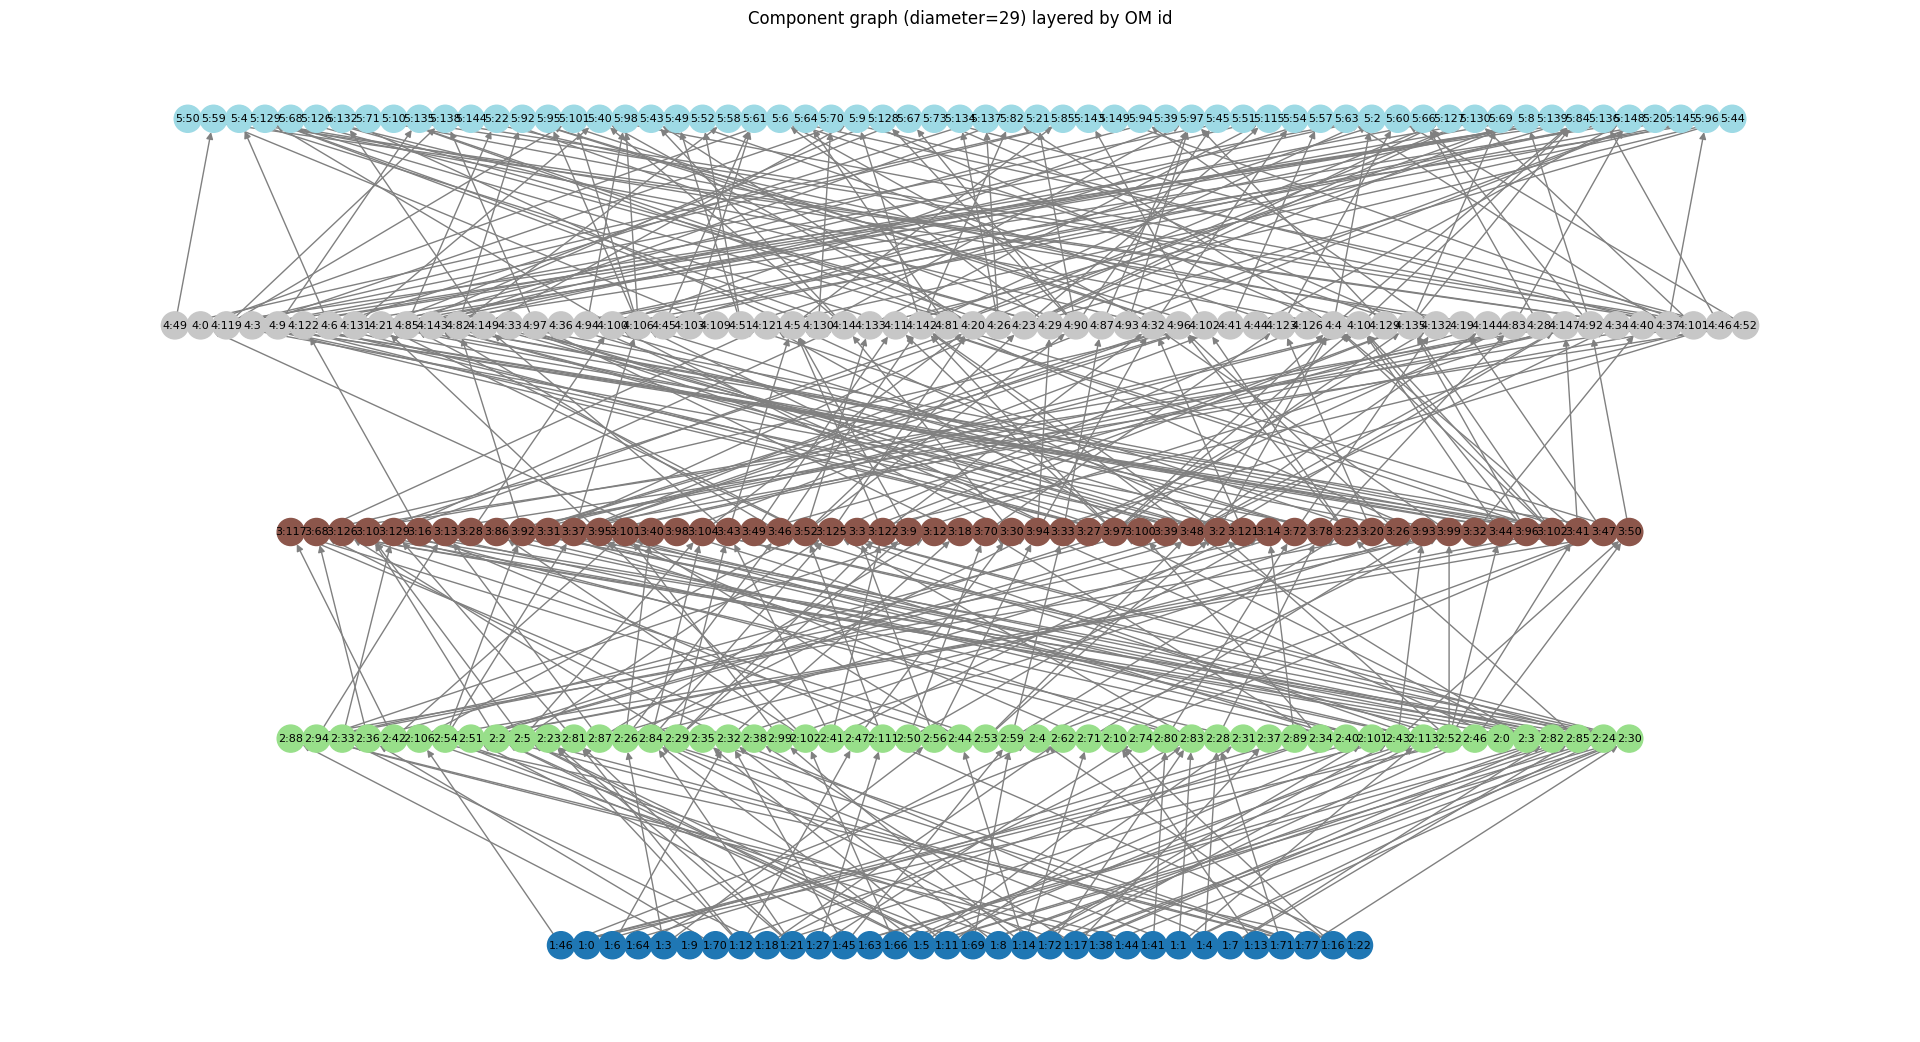

In [ ]:
# Visualization-heavy component analysis disabled to avoid notebook hangs.
# Refer to version control history if the original plotting workflow is needed in the future.

Reusing existing selected component and tracker.
Selected component contains 261 nodes across 5 OMs: [1, 2, 3, 4, 5]


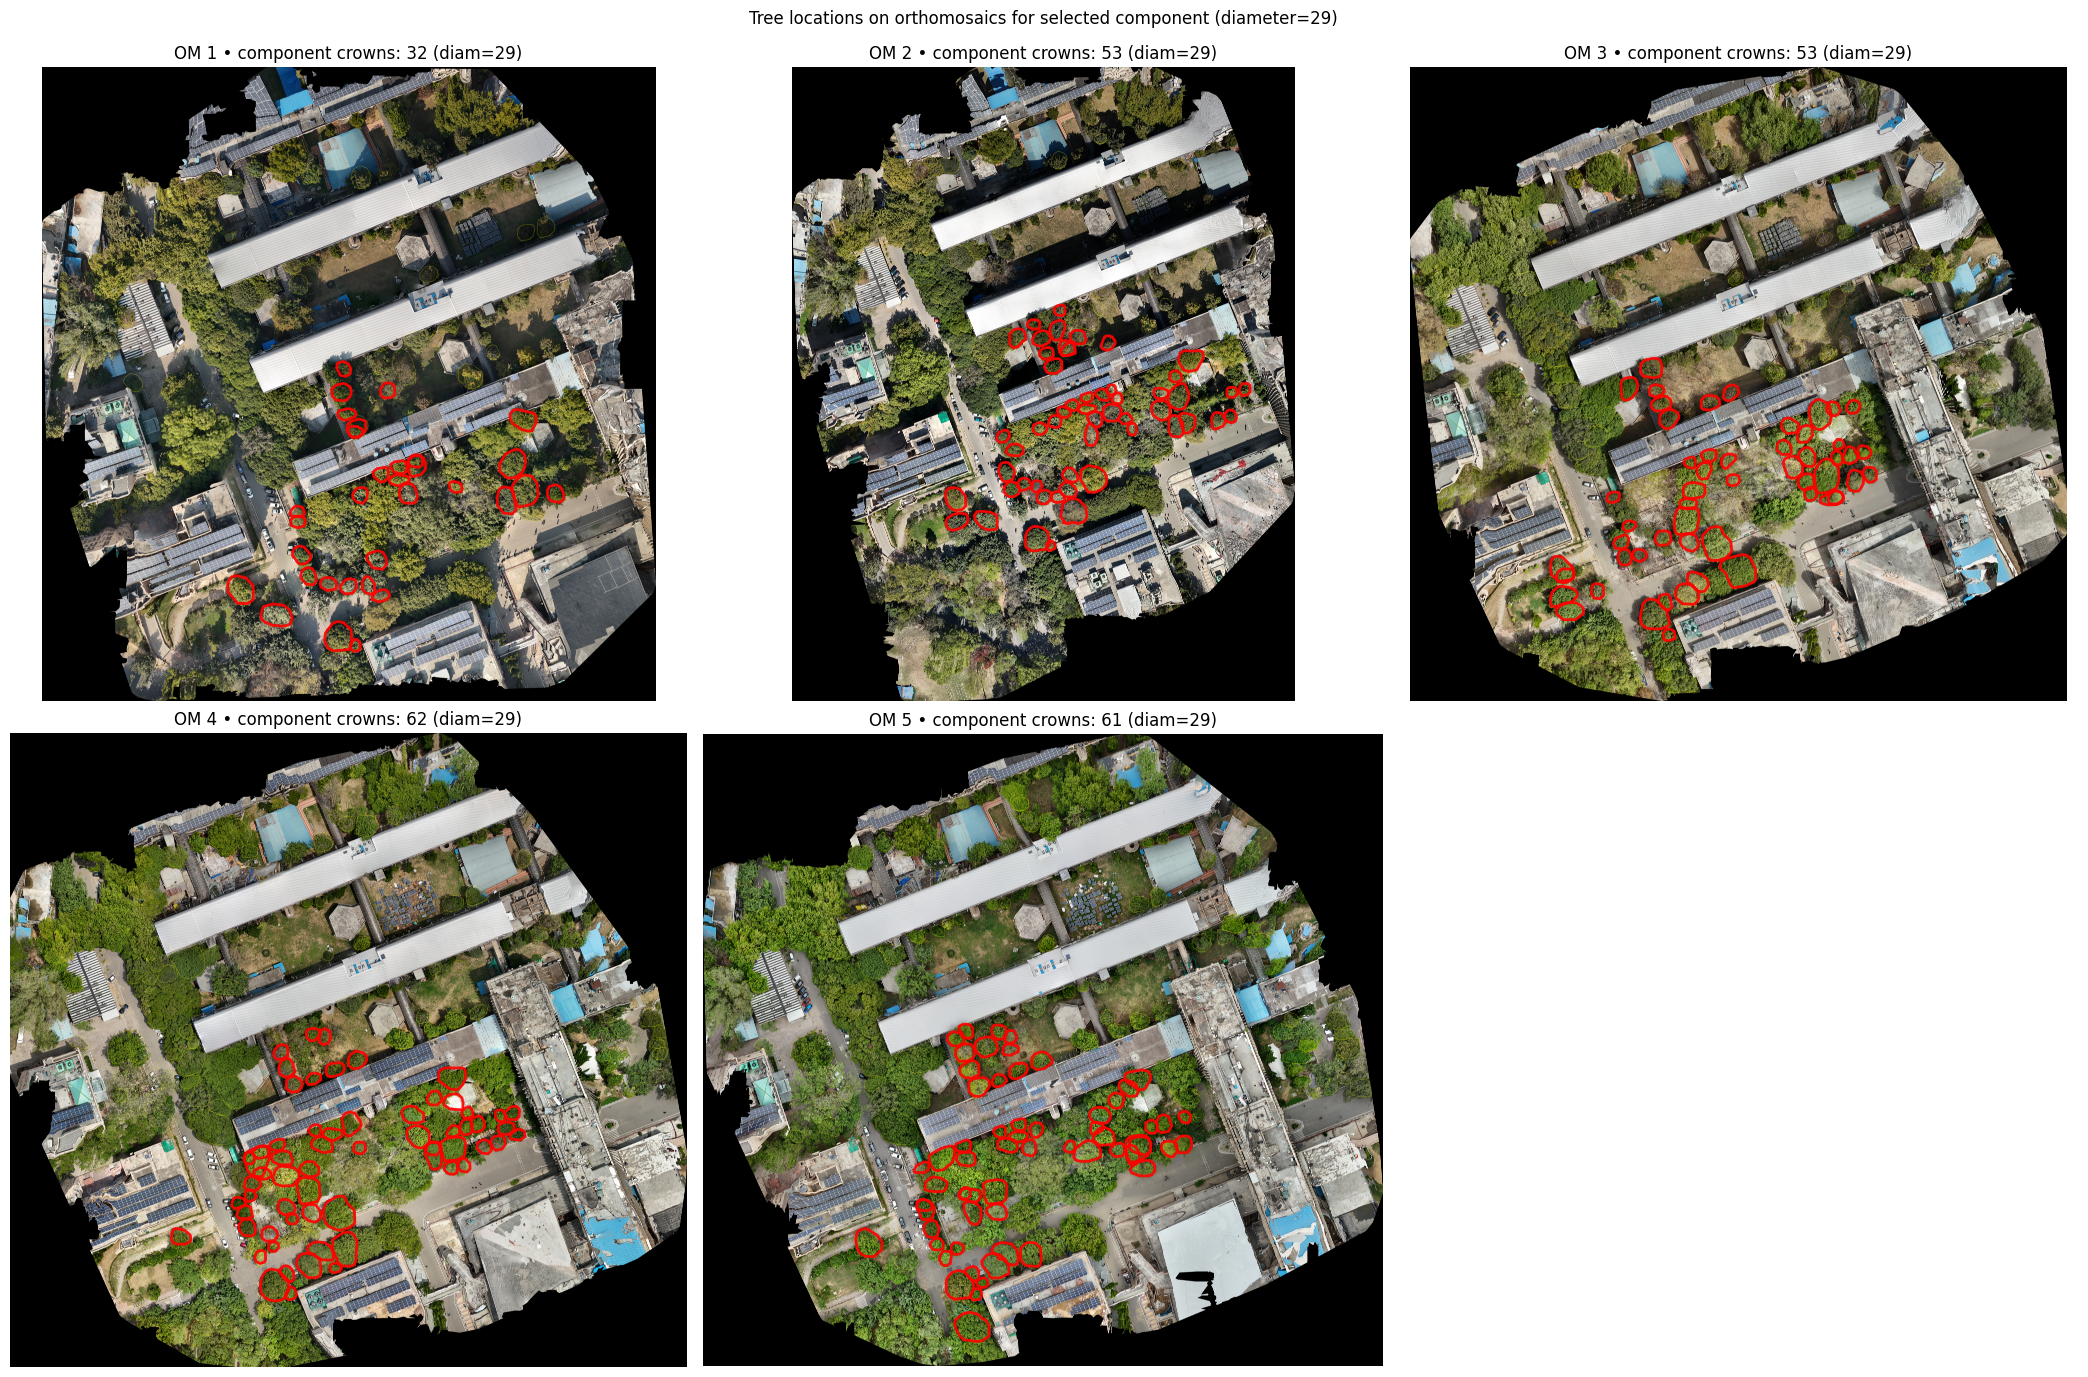

In [ ]:
# Visualization overlay disabled to keep the notebook lightweight.
# Restore the previous implementation from version control if map overlays are required.

In [7]:
# Experiment infrastructure for tuning matching strategies
from dataclasses import dataclass, field
from typing import Dict, Any, Optional, Iterable, List, Tuple
from copy import deepcopy
import math

EXPERIMENT_CACHE: Optional[Dict[str, Any]] = None

@dataclass
class ExperimentSpec:
    name: str
    max_dist: float = 80.0
    conditional_params: Dict[str, Any] = field(default_factory=dict)
    case_updates: Dict[str, Dict[str, Any]] = field(default_factory=dict)
    disable_cases: Iterable[str] = field(default_factory=list)
    case_order: Optional[List[str]] = None
    high_conf_settings: Dict[str, Any] = field(default_factory=dict)
    notes: str = ""
    mode: str = "conditional"
    threshold_params: Dict[str, Any] = field(default_factory=dict)

def _ensure_base_tracker(load_images: bool = False) -> Dict[str, Any]:
    """Load data once and reuse across experiments to avoid repeated IO."""
    global EXPERIMENT_CACHE
    if EXPERIMENT_CACHE is not None:
        return EXPERIMENT_CACHE

    base_tracker = TreeTrackingGraph()
    base_tracker.load_data(load_images=load_images)
    EXPERIMENT_CACHE = {
        'crown_dir': base_tracker.crown_dir,
        'ortho_dir': base_tracker.ortho_dir,
        'file_pairs': list(base_tracker.file_pairs),
        'om_ids': list(base_tracker.om_ids),
        'crowns_gdfs': base_tracker.crowns_gdfs,
        'crown_attrs': base_tracker.crown_attrs,
        'crown_images': base_tracker.crown_images,
        'case_configs': base_tracker.case_configs,
        'case_order': base_tracker.case_order,
    }
    return EXPERIMENT_CACHE

def make_tracker(load_images: bool = False) -> TreeTrackingGraph:
    cache = _ensure_base_tracker(load_images=load_images)
    tracker = TreeTrackingGraph(auto_discover=False)
    tracker.crown_dir = cache['crown_dir']
    tracker.ortho_dir = cache['ortho_dir']
    tracker.file_pairs = list(cache['file_pairs'])
    tracker.om_ids = list(cache['om_ids'])
    tracker.crowns_gdfs = cache['crowns_gdfs']
    tracker.crown_attrs = cache['crown_attrs']
    tracker.crown_images = cache['crown_images']
    tracker.case_configs = {name: replace(cfg) for name, cfg in cache['case_configs'].items()}
    tracker.case_order = list(cache['case_order'])
    return tracker

def _apply_case_updates(base_configs: Dict[str, MatchCaseConfig], updates: Dict[str, Dict[str, Any]], disable_cases: Iterable[str]) -> Dict[str, MatchCaseConfig]:
    configs = {name: replace(cfg) for name, cfg in base_configs.items()}
    for case_name, changes in (updates or {}).items():
        if case_name not in configs:
            continue
        cfg = configs[case_name]
        attr_updates: Dict[str, Any] = {}
        for attr, value in changes.items():
            if attr in {'base_similarity_weights', 'scoring_weights'}:
                merged = dict(getattr(cfg, attr))
                merged.update(value)
                attr_updates[attr] = merged
            else:
                attr_updates[attr] = value
        cfg = replace(cfg, **attr_updates)
        configs[case_name] = cfg
    for case_name in disable_cases or []:
        configs.pop(case_name, None)
    return configs

def _effective_case_order(default_order: List[str], configs: Dict[str, MatchCaseConfig], override: Optional[List[str]]) -> List[str]:
    if override:
        ordered = [case for case in override if case in configs]
        for case in default_order:
            if case not in ordered and case in configs:
                ordered.append(case)
        return ordered
    return [case for case in default_order if case in configs]

def _high_conf_summary(tracker: TreeTrackingGraph, settings: Dict[str, Any]) -> Tuple[int, float, List[List[Tuple[int, int]]]]:
    cfg = {'min_similarity': 0.78, 'allowed_cases': {'one_to_one'}}
    cfg.update(settings or {})
    chains = _filter_high_confidence_chains(
        tracker,
        min_similarity=cfg['min_similarity'],
        allowed_cases=cfg['allowed_cases'],
    )
    if not chains:
        return 0, 0.0, []
    lengths = [len(ch) for ch in chains]
    return len(chains), float(np.mean(lengths)), chains

def run_experiment(spec: ExperimentSpec) -> Dict[str, Any]:
    tracker = make_tracker(load_images=False)
    metadata: Dict[str, Any] = {'spec': spec}

    if spec.mode == 'threshold':
        tp = {'threshold': 0.7, 'max_dist': 100.0}
        tp.update(spec.threshold_params)
        result = tracker.run_end_to_end(
            threshold=tp.get('threshold', 0.7),
            max_dist=tp.get('max_dist', 100.0),
            max_centroid_dist=tp.get('max_centroid_dist'),
            min_iou=tp.get('min_iou'),
            top_k_per_prev=tp.get('top_k_per_prev'),
            load_images=False,
            matching_strategy='threshold',
            save_prefix=None,
        )
    else:
        case_configs = _apply_case_updates(tracker.case_configs, spec.case_updates, spec.disable_cases)
        order = _effective_case_order(tracker.case_order, case_configs, spec.case_order)
        cond_params = {'overlap_gate': 0.3, 'min_base_similarity': 0.2}
        cond_params.update(spec.conditional_params)
        result = tracker.run_end_to_end(
            max_dist=spec.max_dist,
            load_images=False,
            matching_strategy='conditional',
            case_configs=case_configs,
            case_order=order,
            conditional_params=cond_params,
            save_prefix=None,
        )
        metadata['case_configs'] = case_configs
        metadata['case_order'] = order

    hcount, havg, hchains = _high_conf_summary(tracker, spec.high_conf_settings)
    quality = result['quality_metrics']
    complexity = result['complexity_metrics']
    summary = {
        'name': spec.name,
        'mode': spec.mode,
        'notes': spec.notes,
        'nodes': tracker.G.number_of_nodes(),
        'edges': tracker.G.number_of_edges(),
        'overall_match_rate': quality.get('overall_match_rate', 0.0),
        'avg_chain_length': quality.get('average_chain_length', 0.0),
        'max_chain_length': quality.get('max_chain_length', 0),
        'max_diameter': complexity.get('max_diameter', 0),
        'zero_in_degree': complexity.get('zero_in_degree_nodes', 0),
        'zero_out_degree': complexity.get('zero_out_degree_nodes', 0),
        'high_conf_count': hcount,
        'high_conf_avg_len': havg,
        'edges_by_case': dict(tracker.last_selected_counts),
        'tracker': tracker,
        'result': result,
        'high_conf_chains': hchains,
    }
    metadata['summary'] = summary
    return summary

In [8]:
# Define experiment suite
experiment_specs = [
    ExperimentSpec(
        name="strict_v2_no_partial",
        notes="Tighten strict case by disabling partial overlap/proximity and upping thresholds.",
        max_dist=70.0,
        conditional_params={
            'overlap_gate': 0.48,
            'min_base_similarity': 0.35,
            'max_candidates_per_prev': 4,
            'max_candidates_per_curr': 3,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.82,
                'min_iou': 0.4,
                'min_overlap_prev': 0.72,
                'min_overlap_curr': 0.72,
            },
            'containment': {
                'similarity_threshold': 0.74,
                'min_overlap_prev': 0.82,
                'min_overlap_curr': 0.82,
            },
        },
        disable_cases=['partial_overlap', 'proximity'],
        high_conf_settings={'min_similarity': 0.8, 'allowed_cases': {'one_to_one', 'containment'}},
    ),
    ExperimentSpec(
        name="strict_v2_with_partial",
        notes="Allow partial overlap but push IoU and centroid gating to ensure only tight matches.",
        max_dist=75.0,
        conditional_params={
            'overlap_gate': 0.42,
            'min_base_similarity': 0.32,
            'max_candidates_per_prev': 5,
            'max_candidates_per_curr': 4,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.8,
                'min_iou': 0.38,
            },
            'partial_overlap': {
                'similarity_threshold': 0.7,
                'min_iou': 0.28,
                'max_centroid_dist': 45.0,
            },
            'containment': {
                'similarity_threshold': 0.72,
            },
        },
        disable_cases=['proximity'],
        high_conf_settings={'min_similarity': 0.76, 'allowed_cases': {'one_to_one', 'containment'}},
    ),
    ExperimentSpec(
        name="balanced_chain_friendly",
        notes="Balanced config emphasizing chain continuity while still clipping proximity matches.",
        max_dist=85.0,
        conditional_params={
            'overlap_gate': 0.3,
            'min_base_similarity': 0.24,
            'max_candidates_per_prev': 6,
            'max_candidates_per_curr': 5,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.76,
                'min_overlap_prev': 0.6,
                'min_overlap_curr': 0.6,
            },
            'containment': {
                'similarity_threshold': 0.68,
            },
            'partial_overlap': {
                'similarity_threshold': 0.64,
                'min_iou': 0.22,
                'max_centroid_dist': 55.0,
            },
            'merge': {
                'similarity_threshold': 0.6,
                'max_centroid_dist': 60.0,
            },
            'split': {
                'similarity_threshold': 0.6,
                'max_centroid_dist': 60.0,
            },
        },
        disable_cases=['proximity'],
        high_conf_settings={'min_similarity': 0.74, 'allowed_cases': {'one_to_one', 'containment'}},
    ),
    ExperimentSpec(
        name="recall_boost_partial_only",
        notes="Relaxed partial overlap to recover more recall without merges/proximity.",
        max_dist=90.0,
        conditional_params={
            'overlap_gate': 0.25,
            'min_base_similarity': 0.22,
            'max_candidates_per_prev': 7,
            'max_candidates_per_curr': 6,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.74,
            },
            'partial_overlap': {
                'similarity_threshold': 0.58,
                'min_iou': 0.18,
                'min_overlap_prev': 0.28,
                'min_overlap_curr': 0.28,
                'max_centroid_dist': 65.0,
            },
        },
        disable_cases=['containment', 'split', 'merge', 'proximity'],
        high_conf_settings={'min_similarity': 0.72, 'allowed_cases': {'one_to_one'}},
    ),
    ExperimentSpec(
        name="threshold_high_conf",
        notes="Legacy threshold baseline at high cutoff for comparison.",
        mode='threshold',
        threshold_params={
            'threshold': 0.82,
            'max_dist': 80.0,
            'max_centroid_dist': 40.0,
            'min_iou': 0.2,
            'top_k_per_prev': 1,
        },
        high_conf_settings={'min_similarity': 0.8, 'allowed_cases': {'one_to_one'}},
    ),
]

In [9]:
# Execute experiments and compare key metrics
import pandas as pd
from pprint import pprint

experiment_outcomes: Dict[str, Dict[str, Any]] = {}
experiment_table_rows: List[Dict[str, Any]] = []

for spec in experiment_specs:
    print(f"\n>>> Running experiment: {spec.name} ({spec.mode})")
    summary = run_experiment(spec)
    experiment_outcomes[spec.name] = summary
    row = {
        'experiment': summary['name'],
        'mode': summary['mode'],
        'edges': summary['edges'],
        'match_rate': summary['overall_match_rate'],
        'avg_chain': summary['avg_chain_length'],
        'max_chain': summary['max_chain_length'],
        'max_diameter': summary['max_diameter'],
        'high_conf_count': summary['high_conf_count'],
        'high_conf_avg_len': summary['high_conf_avg_len'],
        'zero_in': summary['zero_in_degree'],
        'zero_out': summary['zero_out_degree'],
        'notes': summary['notes'],
    }
    experiment_table_rows.append(row)
    print(f"Edges: {summary['edges']} | Match rate: {summary['overall_match_rate']:.3f} | Max diameter: {summary['max_diameter']}")
    print(f"High-conf chains: {summary['high_conf_count']} (avg length {summary['high_conf_avg_len']:.2f})")
    if summary['edges_by_case']:
        print("Edges by case:")
        for case_name, count in sorted(summary['edges_by_case'].items(), key=lambda kv: (-kv[1], kv[0])):
            print(f"  {case_name:<16} -> {count}")

experiment_df = pd.DataFrame(experiment_table_rows).set_index('experiment')
if not experiment_df.empty:
    sort_columns = ['high_conf_count', 'match_rate', 'edges']
    experiment_df = experiment_df.sort_values(sort_columns, ascending=[False, False, True])
    print("\n=== Experiment summary table ===")
    display(experiment_df[['mode', 'edges', 'match_rate', 'avg_chain', 'max_chain', 'max_diameter', 'high_conf_count', 'high_conf_avg_len', 'zero_in', 'zero_out', 'notes']])
else:
    print("No experiments executed.")


>>> Running experiment: strict_v2_no_partial (conditional)
Edges: 5 | Match rate: 0.011 | Max diameter: 1
High-conf chains: 2 (avg length 2.00)
Edges by case:
  one_to_one       -> 2
  split            -> 2
  merge            -> 1
  containment      -> 0

>>> Running experiment: strict_v2_with_partial (conditional)
Edges: 15 | Match rate: 0.032 | Max diameter: 1
High-conf chains: 3 (avg length 2.00)
Edges by case:
  partial_overlap  -> 9
  one_to_one       -> 3
  split            -> 2
  merge            -> 1
  containment      -> 0

>>> Running experiment: balanced_chain_friendly (conditional)
Edges: 36 | Match rate: 0.076 | Max diameter: 2
High-conf chains: 7 (avg length 2.14)
Edges by case:
  partial_overlap  -> 23
  one_to_one       -> 9
  split            -> 3
  merge            -> 1
  containment      -> 0

>>> Running experiment: recall_boost_partial_only (conditional)
Edges: 68 | Match rate: 0.143 | Max diameter: 3
High-conf chains: 6 (avg length 2.17)
Edges by case:
  partial_

mode  edges  match_rate  avg_chain  \
experiment                                                             
balanced_chain_friendly    conditional     36    0.075630   1.061017   
recall_boost_partial_only  conditional     68    0.142857   1.121864   
strict_v2_with_partial     conditional     15    0.031513   1.024550   
strict_v2_no_partial       conditional      5    0.010504   1.008052   
threshold_high_conf          threshold     29    0.060924   1.048576   

                           max_chain  max_diameter  high_conf_count  \
experiment                                                            
balanced_chain_friendly            3             2                7   
recall_boost_partial_only          4             3                6   
strict_v2_with_partial             2             1                3   
strict_v2_no_partial               2             1                2   
threshold_high_conf                3             2                0   

                           high_conf_avg_len  zero_in  zero_out  \
experiment                                                        
balanced_chain_friendly             2.142857      590       590   
recall_boost_partial_only           2.166667      558       558   
strict_v2_with_partial              2.000000      611       611   
strict_v2_no_partial                2.000000      621       621   
threshold_high_conf                 0.000000      597       597   

                                                                       notes  
experiment                                                                    
balanced_chain_friendly    Balanced config emphasizing chain continuity w...  
recall_boost_partial_only  Relaxed partial overlap to recover more recall...  
strict_v2_with_partial     Allow partial overlap but push IoU and centroi...  
strict_v2_no_partial       Tighten strict case by disabling partial overl...  
threshold_high_conf        Legacy threshold baseline at high cutoff for c...

In [10]:
# Hybrid approach: combine high-precision edges with selective fallbacks
def build_hybrid_tracker(primary_name: str, fallback_name: str, *, similarity_floor: float = 0.7, allowed_cases: Iterable[str] = ('one_to_one',), allow_partial: bool = False) -> Dict[str, Any]:
    if primary_name not in experiment_outcomes or fallback_name not in experiment_outcomes:
        raise ValueError("Run the required experiments before building a hybrid tracker.")

    primary_summary = experiment_outcomes[primary_name]
    fallback_summary = experiment_outcomes[fallback_name]
    primary_tracker: TreeTrackingGraph = primary_summary['tracker']
    fallback_tracker: TreeTrackingGraph = fallback_summary['tracker']

    hybrid = make_tracker(load_images=False)
    hybrid.reset_graph()
    hybrid.last_selected_counts = defaultdict(int)

    # Add all nodes
    for node, data in primary_tracker.G.nodes(data=True):
        hybrid.G.add_node(node, **data)

    # Primary edges (kept as-is)
    for u, v, data in primary_tracker.G.edges(data=True):
        hybrid.G.add_edge(u, v, **data)
        hybrid.last_selected_counts[data.get('case', 'primary')] += 1

    # Track nodes that already have support
    primary_successors = {node for node, _ in hybrid.G.out_degree() if hybrid.G.out_degree(node) > 0}
    primary_predecessors = {node for node, _ in hybrid.G.in_degree() if hybrid.G.in_degree(node) > 0}

    allowed_cases_set = set(allowed_cases)
    appended = 0
    for u, v, data in fallback_tracker.G.edges(data=True):
        case = data.get('case', 'fallback')
        if case not in allowed_cases_set:
            continue
        if data.get('similarity', 0.0) < similarity_floor:
            continue
        if not allow_partial:
            if case == 'partial_overlap' and data.get('iou', 0.0) < 0.3:
                continue
        if u in primary_successors or v in primary_predecessors:
            continue
        if hybrid.G.has_edge(u, v):
            continue
        hybrid.G.add_edge(u, v, **data)
        hybrid.last_selected_counts[case] += 1
        appended += 1

    q_report, q_metrics = hybrid.quality_report()
    c_report, c_metrics = hybrid.complexity_report()
    hcount, havg, hchains = _high_conf_summary(hybrid, {'min_similarity': 0.78, 'allowed_cases': {'one_to_one'}})

    return {
        'tracker': hybrid,
        'quality_metrics': q_metrics,
        'complexity_metrics': c_metrics,
        'quality_report': q_report,
        'complexity_report': c_report,
        'high_conf_count': hcount,
        'high_conf_avg_len': havg,
        'appended_edges': appended,
    }

In [11]:
# Evaluate hybrid combinations
hybrid_runs = {}

hybrid_runs['strict_plus_balanced_partial'] = build_hybrid_tracker(
    'strict_v2_no_partial',
    'balanced_chain_friendly',
    similarity_floor=0.72,
    allowed_cases=('one_to_one', 'partial_overlap'),
    allow_partial=True,
)

hybrid_runs['strict_plus_recall_high'] = build_hybrid_tracker(
    'strict_v2_no_partial',
    'recall_boost_partial_only',
    similarity_floor=0.74,
    allowed_cases=('one_to_one', 'partial_overlap'),
    allow_partial=True,
)

for name, data in hybrid_runs.items():
    qm = data['quality_metrics']
    cm = data['complexity_metrics']
    print(f"\n=== Hybrid: {name} ===")
    print(f"Edges: {cm['num_edges']} | Match rate: {qm['overall_match_rate']:.3f} | Max diameter: {cm['max_diameter']}")
    print(f"High-conf chains: {data['high_conf_count']} (avg length {data['high_conf_avg_len']:.2f}) | appended edges: {data['appended_edges']}")


=== Hybrid: strict_plus_balanced_partial ===
Edges: 16 | Match rate: 0.034 | Max diameter: 2
High-conf chains: 4 (avg length 2.00) | appended edges: 11

=== Hybrid: strict_plus_recall_high ===
Edges: 12 | Match rate: 0.025 | Max diameter: 2
High-conf chains: 4 (avg length 2.00) | appended edges: 7


In [12]:
# Second wave of experiments focusing on case weighting tweaks
experiment_specs_phase2 = [
    ExperimentSpec(
        name="one_to_one_only_high",
        notes="Only one-to-one matches allowed with very high thresholds for precision.",
        max_dist=65.0,
        conditional_params={
            'overlap_gate': 0.5,
            'min_base_similarity': 0.38,
            'max_candidates_per_prev': 3,
            'max_candidates_per_curr': 2,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.85,
                'min_iou': 0.45,
                'min_overlap_prev': 0.78,
                'min_overlap_curr': 0.78,
            },
        },
        disable_cases=['containment', 'partial_overlap', 'split', 'merge', 'proximity'],
        high_conf_settings={'min_similarity': 0.82, 'allowed_cases': {'one_to_one'}},
    ),
    ExperimentSpec(
        name="partial_high_iou_weighted",
        notes="Two-case setup prioritising IoU-heavy partial matches with stricter scoring.",
        max_dist=80.0,
        conditional_params={
            'overlap_gate': 0.35,
            'min_base_similarity': 0.3,
            'max_candidates_per_prev': 4,
            'max_candidates_per_curr': 3,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.8,
                'min_iou': 0.38,
            },
            'partial_overlap': {
                'similarity_threshold': 0.72,
                'min_iou': 0.35,
                'min_overlap_prev': 0.42,
                'min_overlap_curr': 0.42,
                'scoring_weights': {'iou': 0.3, 'overlap_prev': 0.2, 'overlap_curr': 0.2, 'base': 0.25, 'centroid': 0.05},
                'base_similarity_weights': {'spatial': 0.4, 'area': 0.15, 'shape': 0.1, 'iou': 0.35},
                'max_centroid_dist': 45.0,
            },
        },
        disable_cases=['containment', 'split', 'merge', 'proximity'],
        high_conf_settings={'min_similarity': 0.78, 'allowed_cases': {'one_to_one'}},
    ),
    ExperimentSpec(
        name="split_merge_focus",
        notes="Allow limited splits/merges with stricter overlap requirements and capped multiples.",
        max_dist=80.0,
        conditional_params={
            'overlap_gate': 0.38,
            'min_base_similarity': 0.28,
            'max_candidates_per_prev': 5,
            'max_candidates_per_curr': 5,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.78,
            },
            'split': {
                'similarity_threshold': 0.65,
                'min_overlap_prev': 0.55,
                'allow_multiple': True,
                'max_edges_per_prev': 2,
                'max_edges_per_curr': 1,
            },
            'merge': {
                'similarity_threshold': 0.65,
                'min_overlap_curr': 0.55,
                'allow_multiple': True,
                'max_edges_per_prev': 1,
                'max_edges_per_curr': 2,
            },
            'partial_overlap': {
                'similarity_threshold': 0.68,
            },
        },
        disable_cases=['containment', 'proximity'],
        high_conf_settings={'min_similarity': 0.75, 'allowed_cases': {'one_to_one'}},
    ),
    ExperimentSpec(
        name="prox_strict_anchor",
        notes="Reintroduce proximity as last resort with heavy centroid gating and scoring.",
        max_dist=75.0,
        conditional_params={
            'overlap_gate': 0.3,
            'min_base_similarity': 0.26,
            'max_candidates_per_prev': 5,
            'max_candidates_per_curr': 4,
        },
        case_updates={
            'one_to_one': {
                'similarity_threshold': 0.79,
            },
            'partial_overlap': {
                'similarity_threshold': 0.69,
            },
            'proximity': {
                'similarity_threshold': 0.78,
                'max_centroid_dist': 28.0,
                'scoring_weights': {'base': 0.15, 'centroid': 0.55, 'overlap_prev': 0.15, 'overlap_curr': 0.15},
                'base_similarity_weights': {'spatial': 0.7, 'area': 0.1, 'shape': 0.1, 'iou': 0.1},
            },
        },
        disable_cases=['containment'],
        case_order=['one_to_one', 'partial_overlap', 'split', 'merge', 'proximity'],
        high_conf_settings={'min_similarity': 0.78, 'allowed_cases': {'one_to_one'}},
    ),
]

In [13]:
# Execute second-wave experiments
experiment_outcomes_phase2: Dict[str, Dict[str, Any]] = {}
experiment_table_rows_phase2: List[Dict[str, Any]] = []

for spec in experiment_specs_phase2:
    print(f"\n>>> Running experiment (phase2): {spec.name}")
    summary = run_experiment(spec)
    experiment_outcomes_phase2[spec.name] = summary
    experiment_outcomes[f"phase2::{spec.name}"] = summary  # add to global map for hybrid use
    row = {
        'experiment': spec.name,
        'edges': summary['edges'],
        'match_rate': summary['overall_match_rate'],
        'avg_chain': summary['avg_chain_length'],
        'max_chain': summary['max_chain_length'],
        'max_diameter': summary['max_diameter'],
        'high_conf_count': summary['high_conf_count'],
        'high_conf_avg_len': summary['high_conf_avg_len'],
        'notes': summary['notes'],
    }
    experiment_table_rows_phase2.append(row)
    print(f"Edges: {summary['edges']} | Match rate: {summary['overall_match_rate']:.3f} | Max diameter: {summary['max_diameter']}")
    print(f"High-conf chains: {summary['high_conf_count']} (avg length {summary['high_conf_avg_len']:.2f})")

phase2_df = pd.DataFrame(experiment_table_rows_phase2).set_index('experiment')
if not phase2_df.empty:
    phase2_df = phase2_df.sort_values(['high_conf_count', 'match_rate', 'edges'], ascending=[False, False, True])
    print("\n=== Phase 2 experiment summary ===")
    display(phase2_df[['edges', 'match_rate', 'avg_chain', 'max_chain', 'max_diameter', 'high_conf_count', 'high_conf_avg_len', 'notes']])
else:
    print("No phase 2 experiments executed.")


>>> Running experiment (phase2): one_to_one_only_high
Edges: 0 | Match rate: 0.000 | Max diameter: 0
High-conf chains: 0 (avg length 0.00)

>>> Running experiment (phase2): partial_high_iou_weighted
Edges: 3 | Match rate: 0.006 | Max diameter: 1
High-conf chains: 3 (avg length 2.00)

>>> Running experiment (phase2): split_merge_focus
Edges: 16 | Match rate: 0.034 | Max diameter: 2
High-conf chains: 4 (avg length 2.00)

>>> Running experiment (phase2): prox_strict_anchor
Edges: 16 | Match rate: 0.034 | Max diameter: 1
High-conf chains: 3 (avg length 2.00)

=== Phase 2 experiment summary ===


edges  match_rate  avg_chain  max_chain  \
experiment                                                           
split_merge_focus             16    0.033613   1.026230          3   
prox_strict_anchor            16    0.033613   1.026230          2   
partial_high_iou_weighted      3    0.006303   1.004815          2   
one_to_one_only_high           0    0.000000   1.000000          1   

                           max_diameter  high_conf_count  high_conf_avg_len  \
experiment                                                                    
split_merge_focus                     2                4                2.0   
prox_strict_anchor                    1                3                2.0   
partial_high_iou_weighted             1                3                2.0   
one_to_one_only_high                  0                0                0.0   

                                                                       notes  
experiment                                                                    
split_merge_focus          Allow limited splits/merges with stricter over...  
prox_strict_anchor         Reintroduce proximity as last resort with heav...  
partial_high_iou_weighted  Two-case setup prioritising IoU-heavy partial ...  
one_to_one_only_high       Only one-to-one matches allowed with very high...

In [14]:
# Targeted fine-tuning: moderate partial thresholds for better coverage
precision_recall_trade = ExperimentSpec(
    name="partial_moderate_tradeoff",
    notes="Partial overlap tuned for higher recall while keeping IoU emphasis.",
    max_dist=82.0,
    conditional_params={
        'overlap_gate': 0.33,
        'min_base_similarity': 0.28,
        'max_candidates_per_prev': 5,
        'max_candidates_per_curr': 4,
    },
    case_updates={
        'one_to_one': {
            'similarity_threshold': 0.79,
            'min_iou': 0.36,
        },
        'partial_overlap': {
            'similarity_threshold': 0.66,
            'min_iou': 0.3,
            'min_overlap_prev': 0.35,
            'min_overlap_curr': 0.35,
            'scoring_weights': {'base': 0.3, 'iou': 0.28, 'overlap_prev': 0.18, 'overlap_curr': 0.18, 'centroid': 0.06},
            'base_similarity_weights': {'spatial': 0.45, 'area': 0.15, 'shape': 0.1, 'iou': 0.3},
            'max_centroid_dist': 50.0,
        },
    },
    disable_cases=['containment', 'split', 'merge', 'proximity'],
    high_conf_settings={'min_similarity': 0.75, 'allowed_cases': {'one_to_one', 'partial_overlap'}},
)

trade_summary = run_experiment(precision_recall_trade)
experiment_outcomes['phase2::partial_moderate_tradeoff'] = trade_summary
print("\n>>> Targeted experiment: partial_moderate_tradeoff")
print(f"Edges: {trade_summary['edges']} | Match rate: {trade_summary['overall_match_rate']:.3f} | Max diameter: {trade_summary['max_diameter']}")
print(f"High-conf chains: {trade_summary['high_conf_count']} (avg length {trade_summary['high_conf_avg_len']:.2f})")


>>> Targeted experiment: partial_moderate_tradeoff
Edges: 8 | Match rate: 0.017 | Max diameter: 1
High-conf chains: 3 (avg length 2.00)


In [15]:
# Inspect per-case distribution for targeted experiment
print(trade_summary['edges_by_case'])

{'one_to_one': 3, 'partial_overlap': 5}


In [16]:
# Describe high-confidence chains for the trade-off configuration
trade_tracker = trade_summary['tracker']
trade_high_conf = _filter_high_confidence_chains(trade_tracker, min_similarity=0.75, allowed_cases={'one_to_one', 'partial_overlap'})
for idx, chain in enumerate(trade_high_conf, start=1):
    print(f"Chain {idx}: {_describe_chain(chain, trade_tracker)}")

Chain 1: length=2 | cases=['one_to_one'] | avg_sim=0.832 | min_sim=0.832 | nodes=[(1, 69), (2, 85)]
Chain 2: length=2 | cases=['one_to_one'] | avg_sim=0.839 | min_sim=0.839 | nodes=[(4, 3), (5, 9)]
Chain 3: length=2 | cases=['one_to_one'] | avg_sim=0.824 | min_sim=0.824 | nodes=[(4, 142), (5, 82)]


In [18]:
# Quick quality summary for the trade-off run
trade_quality_report = trade_summary['result']['quality_report']
trade_complexity_report = trade_summary['result']['complexity_report']
print(trade_quality_report)
print("\n---\n")
print(trade_complexity_report)

# Tree Tracking Quality Assessment Report

Total Trees Detected: 626
Total Tracking Edges: 8
Overall Match Rate: 0.017
Average Chain Length: 1.01
Maximum Chain Length: 2

Match Rates by Orthomosaic Pair:
- 1->2: 1/80 (0.013)
- 2->3: 1/116 (0.009)
- 3->4: 1/130 (0.008)
- 4->5: 5/150 (0.033)

Chain Length Distribution:
- Length 1: 610 trees
- Length 2: 8 trees

Edge selection by case:
- partial_overlap: 5 / 176 (0.03)
- one_to_one: 3 / 9 (0.33)

---

# Graph Complexity Report

Nodes: 626
Edges: 8
Avg out-degree: 0.013
Avg in-degree: 0.013
Zero out-degree nodes: 618
Zero in-degree nodes: 618
Weakly connected components: 618 (sizes head: [2, 2, 2, 2, 2, 2, 2, 2, 1, 1])
Strongly connected components: 626 (sizes head: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Average diameter: 0.013
Median diameter: 0.000
Max diameter: 1


In [19]:
# Diagnostic utilities to trace edge losses through the conditional matcher
from collections import Counter, defaultdict

def _select_candidates_with_diagnostics(tracker, candidates, configs, case_order, max_dist):
    selection_diag = {
        'global': Counter(),
        'case': defaultdict(Counter),
    }
    selected = []
    used_prev = defaultdict(int)
    used_curr = defaultdict(int)

    for case_name in case_order:
        config = configs.get(case_name)
        if not config:
            continue
        case_candidates = [cand for cand in candidates if cand['case'] == case_name]
        if not case_candidates:
            continue

        diag_case = selection_diag['case'][case_name]
        diag_case['considered'] += len(case_candidates)
        selection_diag['global']['considered'] += len(case_candidates)

        enriched = []
        for cand in case_candidates:
            prev_node = cand['prev_node']
            curr_node = cand['curr_node']
            features = cand['features']

            if config.max_centroid_dist is not None and features['centroid_dist'] > config.max_centroid_dist:
                diag_case['fail_max_centroid'] += 1
                selection_diag['global']['fail_max_centroid'] += 1
                continue
            if features['iou'] < config.min_iou:
                diag_case['fail_min_iou'] += 1
                selection_diag['global']['fail_min_iou'] += 1
                continue
            if features['overlap_prev'] < config.min_overlap_prev:
                diag_case['fail_min_overlap_prev'] += 1
                selection_diag['global']['fail_min_overlap_prev'] += 1
                continue
            if features['overlap_curr'] < config.min_overlap_curr:
                diag_case['fail_min_overlap_curr'] += 1
                selection_diag['global']['fail_min_overlap_curr'] += 1
                continue

            base_similarity, parts = tracker._weighted_similarity(
                cand['prev_attrs'],
                cand['curr_attrs'],
                weights=config.base_similarity_weights,
                max_dist=max_dist,
            )
            score = tracker._score_candidate(base_similarity, parts, features, config)
            if score < config.similarity_threshold:
                diag_case['fail_score_threshold'] += 1
                selection_diag['global']['fail_score_threshold'] += 1
                continue

            cand = cand.copy()
            cand['base_similarity'] = float(base_similarity)
            cand['similarity_parts'] = {k: float(v) for k, v in parts.items()}
            cand['score'] = float(score)
            enriched.append(cand)

        diag_case['enriched'] += len(enriched)
        selection_diag['global']['enriched'] += len(enriched)
        if not enriched:
            continue

        if config.mutual_best:
            best_prev = {}
            best_curr = {}
            for cand in enriched:
                prev_node = cand['prev_node']
                curr_node = cand['curr_node']
                if used_prev.get(prev_node, 0) and not config.allow_multiple:
                    diag_case['skip_prev_already_used_before_best'] += 1
                    selection_diag['global']['skip_prev_already_used_before_best'] += 1
                    continue
                if used_curr.get(curr_node, 0) and not config.allow_multiple:
                    diag_case['skip_curr_already_used_before_best'] += 1
                    selection_diag['global']['skip_curr_already_used_before_best'] += 1
                    continue
                if cand['score'] < config.similarity_threshold:
                    diag_case['fail_score_threshold'] += 1
                    selection_diag['global']['fail_score_threshold'] += 1
                    continue
                if prev_node not in best_prev or cand['score'] > best_prev[prev_node]['score']:
                    best_prev[prev_node] = cand
                if curr_node not in best_curr or cand['score'] > best_curr[curr_node]['score']:
                    best_curr[curr_node] = cand

            for cand in enriched:
                prev_node = cand['prev_node']
                curr_node = cand['curr_node']
                if best_prev.get(prev_node) is not cand or best_curr.get(curr_node) is not cand:
                    diag_case['fail_mutual_best'] += 1
                    selection_diag['global']['fail_mutual_best'] += 1
                    continue

                if not config.allow_multiple:
                    if used_prev.get(prev_node, 0):
                        diag_case['skip_prev_already_used'] += 1
                        selection_diag['global']['skip_prev_already_used'] += 1
                        continue
                    if used_curr.get(curr_node, 0):
                        diag_case['skip_curr_already_used'] += 1
                        selection_diag['global']['skip_curr_already_used'] += 1
                        continue

                if config.max_edges_per_prev is not None and used_prev[prev_node] >= config.max_edges_per_prev:
                    diag_case['skip_max_edges_per_prev'] += 1
                    selection_diag['global']['skip_max_edges_per_prev'] += 1
                    continue
                if config.max_edges_per_curr is not None and used_curr[curr_node] >= config.max_edges_per_curr:
                    diag_case['skip_max_edges_per_curr'] += 1
                    selection_diag['global']['skip_max_edges_per_curr'] += 1
                    continue

                selected.append(cand)
                used_prev[prev_node] += 1
                used_curr[curr_node] += 1
                diag_case['selected'] += 1
                selection_diag['global']['selected'] += 1
        else:
            enriched.sort(key=lambda c: c['score'], reverse=True)
            for cand in enriched:
                prev_node = cand['prev_node']
                curr_node = cand['curr_node']
                if not config.allow_multiple:
                    if used_prev.get(prev_node, 0):
                        diag_case['skip_prev_already_used'] += 1
                        selection_diag['global']['skip_prev_already_used'] += 1
                        continue
                    if used_curr.get(curr_node, 0):
                        diag_case['skip_curr_already_used'] += 1
                        selection_diag['global']['skip_curr_already_used'] += 1
                        continue

                if config.max_edges_per_prev is not None and used_prev[prev_node] >= config.max_edges_per_prev:
                    diag_case['skip_max_edges_per_prev'] += 1
                    selection_diag['global']['skip_max_edges_per_prev'] += 1
                    continue
                if config.max_edges_per_curr is not None and used_curr[curr_node] >= config.max_edges_per_curr:
                    diag_case['skip_max_edges_per_curr'] += 1
                    selection_diag['global']['skip_max_edges_per_curr'] += 1
                    continue

                selected.append(cand)
                used_prev[prev_node] += 1
                used_curr[curr_node] += 1
                diag_case['selected'] += 1
                selection_diag['global']['selected'] += 1

    return selected, selection_diag

def build_graph_conditional_with_diagnostics(
    tracker,
    case_configs,
    case_order,
    base_max_dist=100.0,
    overlap_gate=0.3,
    min_base_similarity=0.2,
    max_candidates_per_prev=None,
    max_candidates_per_curr=None,
 ):
    diagnostics = {
        'initial': Counter(),
        'classification': Counter(),
        'case_candidates': Counter(),
        'trimmed_prev': Counter(),
        'trimmed_curr': Counter(),
        'selection': {
            'global': Counter(),
            'case': defaultdict(Counter),
        },
        'pair_details': [],
    }

    if not tracker.crowns_gdfs:
        tracker.load_data(load_images=False)
    tracker.reset_graph()

    tracker.last_case_counts = {}
    tracker.last_selected_counts = {}

    for idx in range(len(tracker.om_ids)):
        om_id = tracker.om_ids[idx]
        gdf = tracker.crowns_gdfs[om_id]
        for crown_id, row in gdf.iterrows():
            attrs = tracker.crown_attrs[om_id][crown_id]
            tracker.G.add_node((om_id, crown_id), **attrs)

        if idx == 0:
            continue

        prev_om = tracker.om_ids[idx - 1]
        prev_nodes = [(prev_om, i) for i in range(len(tracker.crowns_gdfs[prev_om]))]
        curr_nodes = [(om_id, j) for j in range(len(gdf))]
        total_pairs = len(prev_nodes) * len(curr_nodes)
        diagnostics['initial']['total_pairs'] += total_pairs

        candidates = []
        distance_filtered = 0
        base_filtered = 0
        none_classified = 0

        overlap_counts_prev = defaultdict(int)
        overlap_counts_curr = defaultdict(int)

        for prev_node in prev_nodes:
            prev_attrs = tracker.G.nodes[prev_node]
            for curr_node in curr_nodes:
                curr_attrs = tracker.crown_attrs[om_id][curr_node[1]]
                features = tracker._compute_pair_metrics(prev_attrs, curr_attrs, max_dist=base_max_dist)
                if features['centroid_dist'] > base_max_dist:
                    distance_filtered += 1
                    continue
                if features['base_similarity'] < min_base_similarity and features['iou'] < overlap_gate:
                    base_filtered += 1
                    continue
                candidate = {
                    'prev_node': prev_node,
                    'curr_node': curr_node,
                    'prev_attrs': prev_attrs,
                    'curr_attrs': curr_attrs,
                    'features': features,
                }
                candidates.append(candidate)
                if features['overlap_prev'] >= overlap_gate:
                    overlap_counts_prev[prev_node] += 1
                if features['overlap_curr'] >= overlap_gate:
                    overlap_counts_curr[curr_node] += 1

        diagnostics['initial']['distance_filtered'] += distance_filtered
        diagnostics['initial']['base_filtered'] += base_filtered
        diagnostics['initial']['after_base'] += len(candidates)

        if not candidates:
            diagnostics['pair_details'].append({
                'pair': (prev_om, om_id),
                'total_pairs': total_pairs,
                'after_base': 0,
            })
            continue

        case_counts = defaultdict(int)
        classified_candidates = []
        for cand in candidates:
            case_name = tracker._classify_match_case(
                cand['prev_node'],
                cand['curr_node'],
                cand['features'],
                overlap_counts_prev,
                overlap_counts_curr,
                overlap_gate,
            )
            cand['case'] = case_name
            if case_name == 'none':
                none_classified += 1
                continue
            if case_name not in case_configs:
                diagnostics['selection']['global']['case_disabled'] += 1
                diagnostics['selection']['case'][case_name]['case_disabled'] += 1
                continue
            classified_candidates.append(cand)
            case_counts[case_name] += 1

        diagnostics['classification']['none_classified'] += none_classified
        diagnostics['classification']['after_case'] += len(classified_candidates)
        for case_name, count in case_counts.items():
            diagnostics['case_candidates'][case_name] += count

        if max_candidates_per_prev is not None:
            grouped_prev = defaultdict(list)
            for cand in classified_candidates:
                grouped_prev[cand['prev_node']].append(cand)
            trimmed = []
            for group in grouped_prev.values():
                group.sort(key=lambda c: (c['features']['base_similarity'], c['features']['iou']), reverse=True)
                trimmed.extend(group[max_candidates_per_prev:])
            if trimmed:
                for cand in trimmed:
                    diagnostics['trimmed_prev'][cand['case']] += 1
                classified_candidates = [cand for cand in classified_candidates if cand not in trimmed]

        if max_candidates_per_curr is not None:
            grouped_curr = defaultdict(list)
            for cand in classified_candidates:
                grouped_curr[cand['curr_node']].append(cand)
            trimmed_curr = []
            for group in grouped_curr.values():
                group.sort(key=lambda c: (c['features']['base_similarity'], c['features']['iou']), reverse=True)
                trimmed_curr.extend(group[max_candidates_per_curr:])
            if trimmed_curr:
                for cand in trimmed_curr:
                    diagnostics['trimmed_curr'][cand['case']] += 1
                classified_candidates = [cand for cand in classified_candidates if cand not in trimmed_curr]

        selected, selection_diag = _select_candidates_with_diagnostics(
            tracker,
            classified_candidates,
            case_configs,
            case_order,
            base_max_dist,
        )

        for key, value in selection_diag['global'].items():
            diagnostics['selection']['global'][key] += value
        for case_name, counter in selection_diag['case'].items():
            for key, value in counter.items():
                diagnostics['selection']['case'][case_name][key] += value

        for cand in selected:
            case_name = cand['case']
            features = cand['features']
            similarity_parts = cand.get('similarity_parts', {})
            tracker.G.add_edge(
                cand['prev_node'],
                cand['curr_node'],
                similarity=float(cand.get('score', features['base_similarity'])),
                method='conditional',
                case=case_name,
                overlap_prev=float(features['overlap_prev']),
                overlap_curr=float(features['overlap_curr']),
                iou=float(features['iou']),
                centroid_distance=float(features['centroid_dist']),
                base_similarity=float(cand.get('base_similarity', features['base_similarity'])),
                spatial_similarity=float(similarity_parts.get('spatial', features['spatial_similarity'])),
                area_similarity=float(similarity_parts.get('area', features['area_similarity'])),
                shape_similarity=float(similarity_parts.get('shape', features['shape_similarity'])),
            )

        diagnostics['pair_details'].append({
            'pair': (prev_om, om_id),
            'total_pairs': total_pairs,
            'after_base': len(candidates),
            'after_case': len(classified_candidates),
            'selected': len(selected),
        })

    tracker.last_case_counts = dict(diagnostics['case_candidates'])
    tracker.last_selected_counts = {case: counters.get('selected', 0) for case, counters in diagnostics['selection']['case'].items()}

    return diagnostics

def run_experiment_with_diagnostics(spec: ExperimentSpec):
    tracker = make_tracker(load_images=False)
    metadata = {'spec': spec}

    if spec.mode == 'threshold':
        summary = run_experiment(spec)
        metadata['diagnostics'] = {'note': 'Diagnostics currently available for conditional mode only.'}
        summary['diagnostics'] = metadata['diagnostics']
        return summary

    case_configs = _apply_case_updates(tracker.case_configs, spec.case_updates, spec.disable_cases)
    order = _effective_case_order(tracker.case_order, case_configs, spec.case_order)
    cond_params = {'overlap_gate': 0.3, 'min_base_similarity': 0.2}
    cond_params.update(spec.conditional_params)

    diagnostics = build_graph_conditional_with_diagnostics(
        tracker,
        case_configs,
        order,
        base_max_dist=spec.max_dist,
        overlap_gate=cond_params.get('overlap_gate', 0.3),
        min_base_similarity=cond_params.get('min_base_similarity', 0.2),
        max_candidates_per_prev=cond_params.get('max_candidates_per_prev'),
        max_candidates_per_curr=cond_params.get('max_candidates_per_curr'),
    )

    quality_report, quality_metrics = tracker.quality_report()
    complexity_report, complexity_metrics = tracker.complexity_report()

    summary = {
        'name': spec.name,
        'mode': spec.mode,
        'notes': spec.notes,
        'nodes': tracker.G.number_of_nodes(),
        'edges': tracker.G.number_of_edges(),
        'overall_match_rate': quality_metrics.get('overall_match_rate', 0.0),
        'avg_chain_length': quality_metrics.get('average_chain_length', 0.0),
        'max_chain_length': quality_metrics.get('max_chain_length', 0),
        'max_diameter': complexity_metrics.get('max_diameter', 0),
        'quality_report': quality_report,
        'complexity_report': complexity_report,
        'quality_metrics': quality_metrics,
        'complexity_metrics': complexity_metrics,
        'tracker': tracker,
        'diagnostics': diagnostics,
    }

    return summary

In [20]:
# Diagnose where edges are lost for the trade-off configuration
trade_summary = run_experiment_with_diagnostics(precision_recall_trade)
trade_tracker = trade_summary['tracker']
trade_diagnostics = trade_summary['diagnostics']

initial_counts = trade_diagnostics['initial']
classification_counts = trade_diagnostics['classification']
case_candidate_counts = trade_diagnostics['case_candidates']
trim_prev = trade_diagnostics['trimmed_prev']
trim_curr = trade_diagnostics['trimmed_curr']
selection_global = trade_diagnostics['selection']['global']
selection_case = trade_diagnostics['selection']['case']

print("Initial candidate screening:")
print({k: int(v) for k, v in initial_counts.items()})
print("\nPost-classification counts:")
print({k: int(v) for k, v in classification_counts.items()})
print("\nCandidates per case (after classification):")
print({k: int(v) for k, v in case_candidate_counts.items()})

case_rows = []
all_cases = sorted(set(case_candidate_counts.keys()) | set(selection_case.keys()))
for case in all_cases:
    diag = selection_case.get(case, Counter())
    row = {
        'case': case,
        'candidates': int(case_candidate_counts.get(case, 0)),
        'trim_prev': int(trim_prev.get(case, 0)),
        'trim_curr': int(trim_curr.get(case, 0)),
        'considered': int(diag.get('considered', 0)),
        'fail_max_centroid': int(diag.get('fail_max_centroid', 0)),
        'fail_min_iou': int(diag.get('fail_min_iou', 0)),
        'fail_min_overlap_prev': int(diag.get('fail_min_overlap_prev', 0)),
        'fail_min_overlap_curr': int(diag.get('fail_min_overlap_curr', 0)),
        'fail_score_threshold': int(diag.get('fail_score_threshold', 0)),
        'fail_mutual_best': int(diag.get('fail_mutual_best', 0)),
        'skip_prev_already_used': int(diag.get('skip_prev_already_used', 0)),
        'skip_curr_already_used': int(diag.get('skip_curr_already_used', 0)),
        'skip_max_edges_per_prev': int(diag.get('skip_max_edges_per_prev', 0)),
        'skip_max_edges_per_curr': int(diag.get('skip_max_edges_per_curr', 0)),
        'selected': int(diag.get('selected', 0)),
    }
    case_rows.append(row)

diag_df = pd.DataFrame(case_rows).set_index('case').sort_index()
display(diag_df)

print("\nGlobal selection counters:")
print({k: int(v) for k, v in selection_global.items()})

trade_edges_by_case = {case: int(counter.get('selected', 0)) for case, counter in selection_case.items()}
print("\nFinal edges by case:", trade_edges_by_case)
print(f"Total edges: {trade_summary['edges']}")

Initial candidate screening:
{'total_pairs': 66360, 'distance_filtered': 38613, 'base_filtered': 1221, 'after_base': 26526}

Post-classification counts:
{'none_classified': 22501, 'after_case': 200}

Candidates per case (after classification):
{'partial_overlap': 191, 'one_to_one': 9}


candidates  trim_prev  trim_curr  considered  \
case                                                            
containment               0          0          0           0   
merge                     0          0          0           0   
one_to_one                9          0          0           9   
partial_overlap         191          0          0         191   
proximity                 0          0          0           0   
split                     0          0          0           0   

                 fail_max_centroid  fail_min_iou  fail_min_overlap_prev  \
case                                                                      
containment                      0             0                      0   
merge                            0             0                      0   
one_to_one                       0             0                      0   
partial_overlap                  0           143                      0   
proximity                        0             0                      0   
split                            0             0                      0   

                 fail_min_overlap_curr  fail_score_threshold  \
case                                                           
containment                          0                     0   
merge                                0                     0   
one_to_one                           0                     6   
partial_overlap                      1                    42   
proximity                            0                     0   
split                                0                     0   

                 fail_mutual_best  skip_prev_already_used  \
case                                                        
containment                     0                       0   
merge                           0                       0   
one_to_one                      0                       0   
partial_overlap                 0                       0   
proximity                       0                       0   
split                           0                       0   

                 skip_curr_already_used  skip_max_edges_per_prev  \
case                                                               
containment                           0                        0   
merge                                 0                        0   
one_to_one                            0                        0   
partial_overlap                       0                        0   
proximity                             0                        0   
split                                 0                        0   

                 skip_max_edges_per_curr  selected  
case                                                
containment                            0         0  
merge                                  0         0  
one_to_one                             0         3  
partial_overlap                        0         5  
proximity                              0         0  
split                                  0         0


Global selection counters:
{'case_disabled': 3825, 'considered': 200, 'enriched': 8, 'selected': 8, 'fail_min_iou': 143, 'fail_score_threshold': 48, 'fail_min_overlap_curr': 1}

Final edges by case: {'proximity': 0, 'split': 0, 'merge': 0, 'one_to_one': 3, 'partial_overlap': 5, 'containment': 0}
Total edges: 8


In [21]:
def display_diagnostics(summary):
    diagnostics = summary['diagnostics']
    initial_counts = diagnostics['initial']
    classification_counts = diagnostics['classification']
    case_candidate_counts = diagnostics['case_candidates']
    trim_prev = diagnostics['trimmed_prev']
    trim_curr = diagnostics['trimmed_curr']
    selection_global = diagnostics['selection']['global']
    selection_case = diagnostics['selection']['case']

    print("Initial candidate screening:")
    print({k: int(v) for k, v in initial_counts.items()})
    print("\nPost-classification counts:")
    print({k: int(v) for k, v in classification_counts.items()})
    print("\nCandidates per case (after classification):")
    print({k: int(v) for k, v in case_candidate_counts.items()})

    case_rows = []
    all_cases = sorted(set(case_candidate_counts.keys()) | set(selection_case.keys()))
    for case in all_cases:
        diag = selection_case.get(case, Counter())
        row = {
            'case': case,
            'candidates': int(case_candidate_counts.get(case, 0)),
            'trim_prev': int(trim_prev.get(case, 0)),
            'trim_curr': int(trim_curr.get(case, 0)),
            'considered': int(diag.get('considered', 0)),
            'fail_max_centroid': int(diag.get('fail_max_centroid', 0)),
            'fail_min_iou': int(diag.get('fail_min_iou', 0)),
            'fail_min_overlap_prev': int(diag.get('fail_min_overlap_prev', 0)),
            'fail_min_overlap_curr': int(diag.get('fail_min_overlap_curr', 0)),
            'fail_score_threshold': int(diag.get('fail_score_threshold', 0)),
            'fail_mutual_best': int(diag.get('fail_mutual_best', 0)),
            'skip_prev_already_used': int(diag.get('skip_prev_already_used', 0)),
            'skip_curr_already_used': int(diag.get('skip_curr_already_used', 0)),
            'skip_max_edges_per_prev': int(diag.get('skip_max_edges_per_prev', 0)),
            'skip_max_edges_per_curr': int(diag.get('skip_max_edges_per_curr', 0)),
            'selected': int(diag.get('selected', 0)),
        }
        case_rows.append(row)

    diag_df = pd.DataFrame(case_rows).set_index('case').sort_index() if case_rows else pd.DataFrame()
    if not diag_df.empty:
        display(diag_df)
    else:
        print("No case-level diagnostics available.")

    print("\nGlobal selection counters:")
    print({k: int(v) for k, v in selection_global.items()})
    edges_by_case = {case: int(counter.get('selected', 0)) for case, counter in selection_case.items()}
    print("\nFinal edges by case:", edges_by_case)
    print(f"Total edges: {summary['edges']}")

In [22]:
# Iteration 1: relax partial-overlap gating while adding high-confidence containment
partial_trade_v2 = ExperimentSpec(
    name="partial_trade_v2",
    notes="Lower partial IoU/score thresholds slightly and re-enable containment with strict overlap.",
    max_dist=82.0,
    conditional_params={
        'overlap_gate': 0.32,
        'min_base_similarity': 0.27,
        'max_candidates_per_prev': 6,
        'max_candidates_per_curr': 5,
    },
    case_updates={
        'one_to_one': {
            'similarity_threshold': 0.78,
            'min_iou': 0.34,
        },
        'partial_overlap': {
            'similarity_threshold': 0.63,
            'min_iou': 0.25,
            'min_overlap_prev': 0.3,
            'min_overlap_curr': 0.3,
            'scoring_weights': {'base': 0.28, 'iou': 0.3, 'overlap_prev': 0.18, 'overlap_curr': 0.18, 'centroid': 0.06},
            'base_similarity_weights': {'spatial': 0.42, 'area': 0.13, 'shape': 0.1, 'iou': 0.35},
            'max_centroid_dist': 52.0,
        },
        'containment': {
            'similarity_threshold': 0.8,
            'min_overlap_prev': 0.85,
            'min_overlap_curr': 0.85,
            'min_iou': 0.4,
            'max_centroid_dist': 45.0,
        },
    },
    disable_cases=['split', 'merge', 'proximity'],
    high_conf_settings={'min_similarity': 0.75, 'allowed_cases': {'one_to_one', 'partial_overlap', 'containment'}},
)

partial_trade_v2_summary = run_experiment_with_diagnostics(partial_trade_v2)
display_diagnostics(partial_trade_v2_summary)

partial_trade_v2_tracker = partial_trade_v2_summary['tracker']
partial_trade_v2_diagnostics = partial_trade_v2_summary['diagnostics']

Initial candidate screening:
{'total_pairs': 66360, 'distance_filtered': 38613, 'base_filtered': 890, 'after_base': 26857}

Post-classification counts:
{'none_classified': 22832, 'after_case': 207}

Candidates per case (after classification):
{'partial_overlap': 195, 'one_to_one': 9, 'containment': 3}


candidates  trim_prev  trim_curr  considered  \
case                                                            
containment               3          0          0           3   
merge                     0          0          0           0   
one_to_one                9          0          0           9   
partial_overlap         195          0          0         195   
proximity                 0          0          0           0   
split                     0          0          0           0   

                 fail_max_centroid  fail_min_iou  fail_min_overlap_prev  \
case                                                                      
containment                      0             3                      0   
merge                            0             0                      0   
one_to_one                       0             0                      0   
partial_overlap                  0           118                      2   
proximity                        0             0                      0   
split                            0             0                      0   

                 fail_min_overlap_curr  fail_score_threshold  \
case                                                           
containment                          0                     0   
merge                                0                     0   
one_to_one                           0                     5   
partial_overlap                      3                    64   
proximity                            0                     0   
split                                0                     0   

                 fail_mutual_best  skip_prev_already_used  \
case                                                        
containment                     0                       0   
merge                           0                       0   
one_to_one                      0                       0   
partial_overlap                 0                       0   
proximity                       0                       0   
split                           0                       0   

                 skip_curr_already_used  skip_max_edges_per_prev  \
case                                                               
containment                           0                        0   
merge                                 0                        0   
one_to_one                            0                        0   
partial_overlap                       0                        0   
proximity                             0                        0   
split                                 0                        0   

                 skip_max_edges_per_curr  selected  
case                                                
containment                            0         0  
merge                                  0         0  
one_to_one                             0         4  
partial_overlap                        0         8  
proximity                              0         0  
split                                  0         0


Global selection counters:
{'case_disabled': 3818, 'considered': 207, 'enriched': 12, 'selected': 12, 'fail_min_iou': 121, 'fail_score_threshold': 69, 'fail_min_overlap_prev': 2, 'fail_min_overlap_curr': 3}

Final edges by case: {'proximity': 0, 'split': 0, 'merge': 0, 'one_to_one': 4, 'partial_overlap': 8, 'containment': 0}
Total edges: 12


In [23]:
print({
    'edges': partial_trade_v2_summary['edges'],
    'match_rate': partial_trade_v2_summary['overall_match_rate'],
    'max_chain': partial_trade_v2_summary['max_chain_length'],
    'max_diameter': partial_trade_v2_summary['max_diameter'],
    'high_conf_count': partial_trade_v2_summary['quality_metrics'].get('high_conf_count', None) if 'quality_metrics' in partial_trade_v2_summary else None,
})

{'edges': 12, 'match_rate': 0.025210084033613446, 'max_chain': 2, 'max_diameter': 1, 'high_conf_count': None}


In [24]:
partial_v2_high_conf = _filter_high_confidence_chains(partial_trade_v2_tracker, min_similarity=0.75, allowed_cases={'one_to_one', 'containment'})
print(f"High-confidence chains (len={len(partial_v2_high_conf)}):")
for idx, chain in enumerate(partial_v2_high_conf, start=1):
    print(f"  {idx:02d}. {_describe_chain(chain, partial_trade_v2_tracker)}")

High-confidence chains (len=4):
  01. length=2 | cases=['one_to_one'] | avg_sim=0.832 | min_sim=0.832 | nodes=[(1, 69), (2, 85)]
  02. length=2 | cases=['one_to_one'] | avg_sim=0.785 | min_sim=0.785 | nodes=[(2, 40), (3, 16)]
  03. length=2 | cases=['one_to_one'] | avg_sim=0.839 | min_sim=0.839 | nodes=[(4, 3), (5, 9)]
  04. length=2 | cases=['one_to_one'] | avg_sim=0.824 | min_sim=0.824 | nodes=[(4, 142), (5, 82)]


In [25]:
print(partial_trade_v2_summary['quality_report'])
print("\n---\n")
print(partial_trade_v2_summary['complexity_report'])

# Tree Tracking Quality Assessment Report

Total Trees Detected: 626
Total Tracking Edges: 12
Overall Match Rate: 0.025
Average Chain Length: 1.02
Maximum Chain Length: 2

Match Rates by Orthomosaic Pair:
- 1->2: 2/80 (0.025)
- 2->3: 3/116 (0.026)
- 3->4: 2/130 (0.015)
- 4->5: 5/150 (0.033)

Chain Length Distribution:
- Length 1: 602 trees
- Length 2: 12 trees

Edge selection by case:
- partial_overlap: 8 / 195 (0.04)
- one_to_one: 4 / 9 (0.44)
- containment: 0 / 3 (0.00)
- merge: 0
- proximity: 0
- split: 0

---

# Graph Complexity Report

Nodes: 626
Edges: 12
Avg out-degree: 0.019
Avg in-degree: 0.019
Zero out-degree nodes: 614
Zero in-degree nodes: 614
Weakly connected components: 614 (sizes head: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Strongly connected components: 626 (sizes head: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Average diameter: 0.020
Median diameter: 0.000
Max diameter: 1
